In [1]:
pip install heartpy wfdb shap

     |████████████████████████████████| 1.0 MB 6.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


#Create Functions

In [6]:
import numpy as np
import scipy.signal
from scipy.fftpack import fft, fftfreq
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pywt
import heartpy as hp
from scipy.signal import butter, lfilter
import pywt

def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def preprocess_signal(signal, fs):
    # Bandpass filtering
    signal = bandpass_filter(signal, 0.5, 5.0, fs)  # Adjust these values as needed

    return signal

def global_features(signal, fs, is_ecg=False):

    signal = preprocess_signal(signal, fs)
    return common_features(signal, fs, is_ecg)

def local_features(signal, fs, is_ecg=False):
    features_list = []

    # Constants defining the number of windows and the number of features
    NUM_WINDOWS = 6
    NUM_FEATURES_PER_WINDOW = 10
    window_size = len(signal) // NUM_WINDOWS

    cutoff_freq = 10.0  # You can adjust this based on your knowledge of the signal
    signal = preprocess_signal(signal, fs)

    for i in range(NUM_WINDOWS):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        neighborhood = signal[start_idx:end_idx]

        features = common_features(neighborhood, fs, is_ecg)
        selected_features = [features[key] for key in sorted(features.keys())]#[:NUM_FEATURES_PER_WINDOW]]
        features_list.append(features)

    return features_list

def common_features(signal, fs, is_ecg=False):
    features = {}

    # Ensure signal is a 1D array
    signal = np.squeeze(signal)

    # Check for NaN values and handle them if necessary
    if np.isnan(signal).any():
        signal = signal[~np.isnan(signal)]

    # Verify if the signal has at least one element to avoid errors
    if signal.size == 0:
        # Handle the empty signal case by returning empty features
        return features

    features['mean'] = np.mean(signal)
    features['median'] = np.median(signal)
    features['variance'] = np.var(signal)
    features['std_dev'] = np.std(signal)
    features['skewness'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)

    peaks, _ = scipy.signal.find_peaks(signal)
    valleys, _ = scipy.signal.find_peaks(-signal)
    features['num_peaks'] = len(peaks)
    features['num_valleys'] = len(valleys)

    fft_vals = fft(signal)
    fft_freq = fftfreq(len(signal), 1/fs)
    norm_vals = np.abs(fft_vals)
    norm_vals = norm_vals / sum(norm_vals)
    features['spectral_entropy'] = -sum(norm_vals * np.log2(norm_vals))

    freqs, psd_values = welch(signal, fs=fs)
    features['dom_freq'] = freqs[np.argmax(psd_values)]

    cA, cD = pywt.dwt(signal, 'db1')

    if is_ecg:
      # HeartPy analysis
      wd, m = hp.process(hp.scale_data(signal), fs)  # Error line

      features['mean_nni'] = m['bpm']
      features['sdnn'] = m['sdnn']
      features['sdsd'] = m['sdsd']
      features['pnn20'] = m['pnn20']
      features['pnn50'] = m['pnn50']
      features['rmssd'] = m['rmssd']
      features['sd1'] = m['sd1']
      features['sd2'] = m['sd2']
      features['respiratory_rate'] = m['breathingrate']

    return features

def estimate_respiratory_rate(signal, fs):
    freqs, psd_values = welch(signal, fs=fs)
    respiratory_freq_range = (freqs >= 0.2) & (freqs <= 0.5)

    if np.any(respiratory_freq_range):  # Check if there are any values within the specified range
        dominant_respiratory_freq = freqs[respiratory_freq_range][np.argmax(psd_values[respiratory_freq_range])]
        respiratory_rate = dominant_respiratory_freq * 60
    else:
        respiratory_rate = np.nan  # Return NaN if no values are found within the specified range

    return respiratory_rate

def detect_motion_artifact(signal, threshold=1.0):
    first_derivative = np.abs(np.gradient(signal))
    return np.mean(first_derivative) > threshold

#Duration Calculation

In [3]:
import os
import wfdb

labels = []
durations = []

# Iterate through all files in the directory
folder_path = '/Users/roupenminassian/physionet.org/files/pulse-transit-time-ppg/1.1.0/Data/'
fs = 500

for filename in os.listdir(folder_path):
    if filename.endswith(".dat"): # Assuming the wfdb data format with .dat extension
        # Extract the label from the filename (e.g., "sit" from "s20_sit")
        label = filename.split('_')[1].split('.')[0]
        labels.append(label)

        # Construct the record name without extensions
        record_name = os.path.join(folder_path, filename.split('.')[0])

        # Load the record using wfdb
        record = wfdb.rdrecord(record_name)

        # Extract ECG signal
        ecg_index = record.sig_name.index('ecg')
        ecg_signal = record.p_signal

        # Compute the duration for the signal
        duration = len(ecg_signal) / fs
        durations.append(duration)

# Group durations by label
grouped_durations = {}
for label, duration in zip(labels, durations):
    if label not in grouped_durations:
        grouped_durations[label] = []
    grouped_durations[label].append(duration)

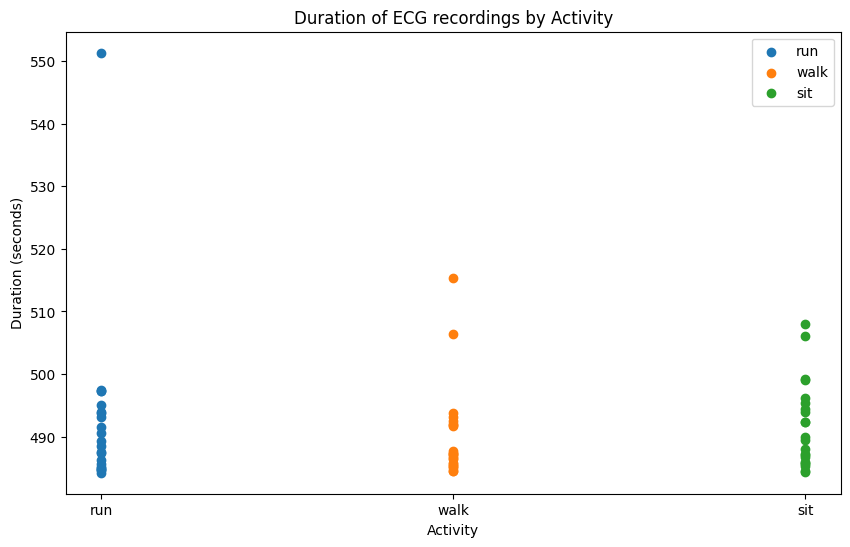

In [4]:
import matplotlib.pyplot as plt

# Prepare data for plotting
labels = list(grouped_durations.keys())
durations_list = [grouped_durations[label] for label in labels]

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
for label, durations in zip(labels, durations_list):
    ax.scatter([label] * len(durations), durations, label=label)

ax.set_title('Duration of ECG recordings by Activity')
ax.set_xlabel('Activity')
ax.set_ylabel('Duration (seconds)')
ax.legend()
plt.show()

#Visualisations

##Global Features

In [7]:
import os
import numpy as np
import scipy.signal
from scipy.fftpack import fft, fftfreq
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pywt
import heartpy as hp
import wfdb
import matplotlib.pyplot as plt

# Include all the functions you provided, such as bandpass_filter, preprocess_signal, global_features, etc.

# Constants
fs = 500  # Sampling frequency

# Dictionary to hold features for each label
features_by_label = {'run': [], 'walk': [], 'sit': []}

# Iterate through all files in the directory
folder_path = '/Users/roupenminassian/physionet.org/files/pulse-transit-time-ppg/1.1.0/Data/'  # Specify the path to your folder
for filename in os.listdir(folder_path):
    if filename.endswith(".dat"):
        # Extract the label from the filename
        label = filename.split('_')[1].split('.')[0]

        # Construct the record name without extensions
        record_name = os.path.join(folder_path, filename.split('.')[0])

        # Load the record using wfdb
        record = wfdb.rdrecord(record_name)

        # Extract ECG and PPG signals
        ecg_index = record.sig_name.index('ecg')
        ecg_signal = record.p_signal[:, ecg_index]
        pleth_2_index = record.sig_name.index('pleth_2')
        pleth_2_signal = record.p_signal[:, pleth_2_index]

        # Calculate global features
        ecg_features = global_features(ecg_signal, fs, is_ecg=True)
        pleth_2_features = global_features(pleth_2_signal, fs)

        # Add ECG and PPG features to the corresponding label
        features_by_label[label].append((ecg_features, pleth_2_features))

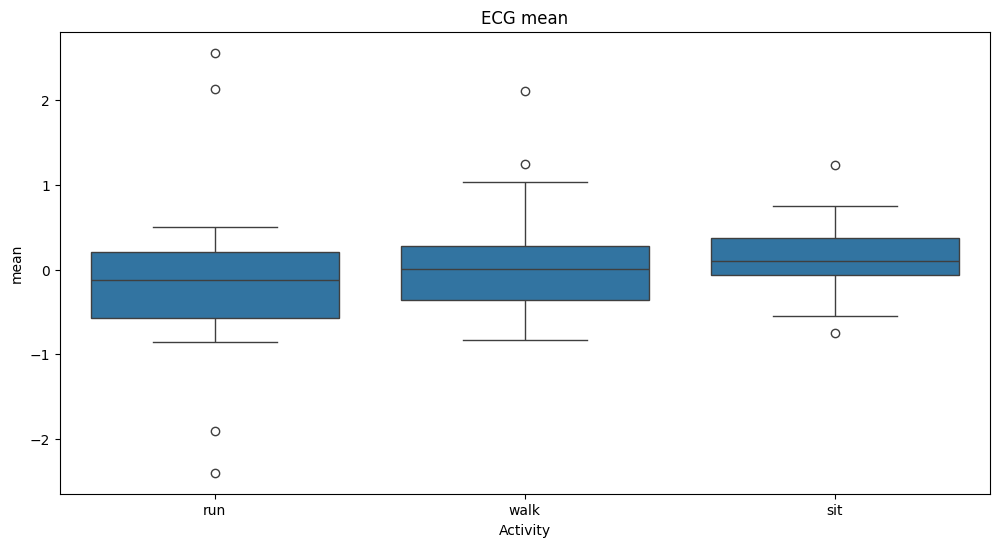

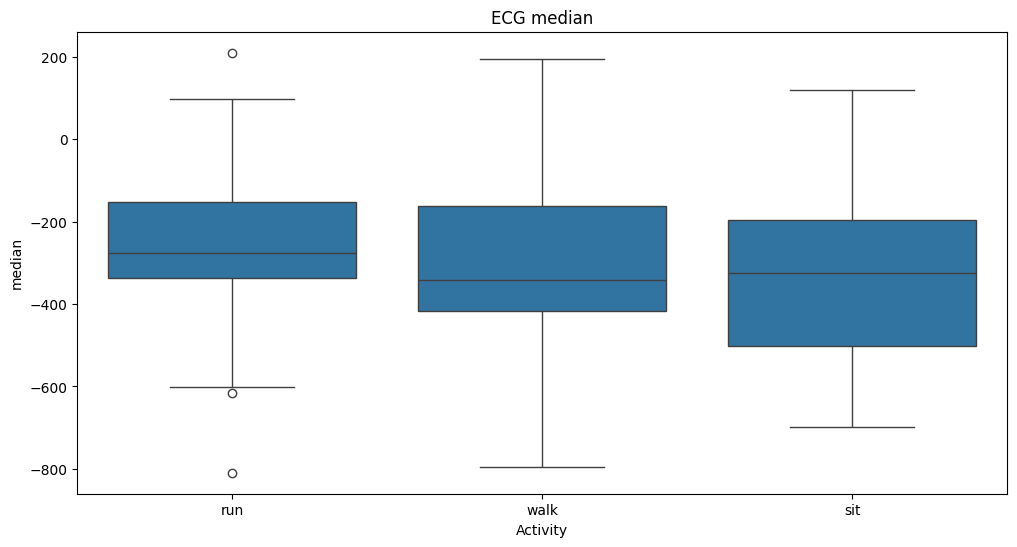

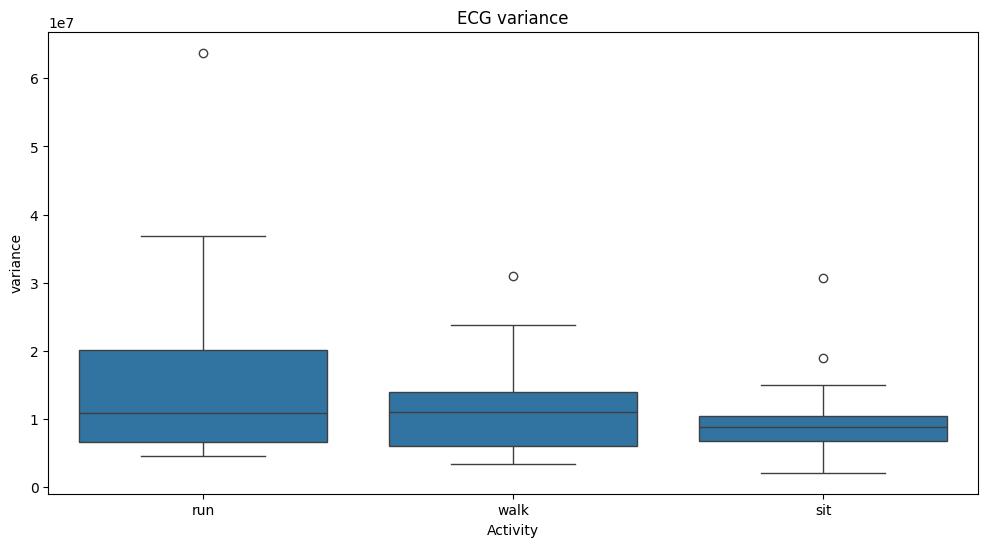

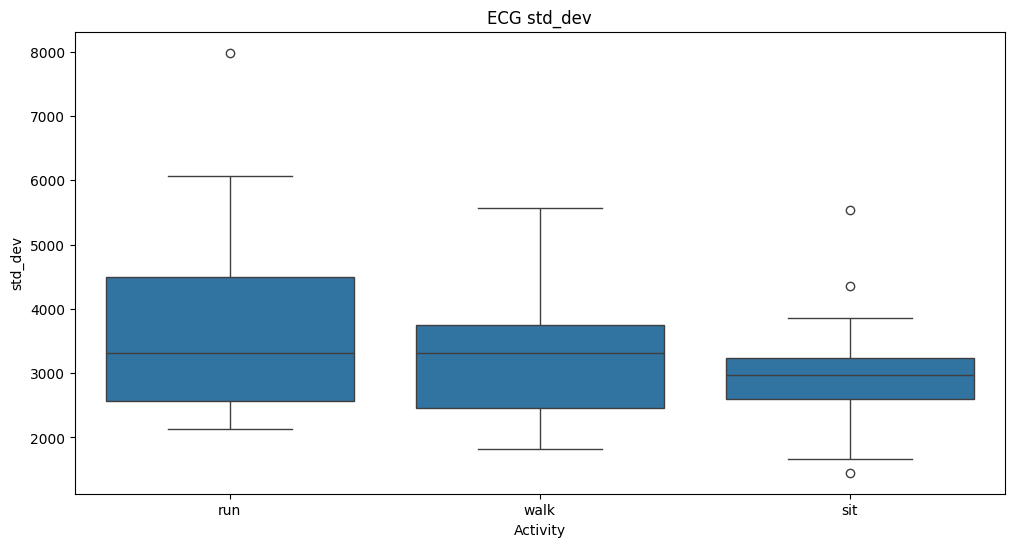

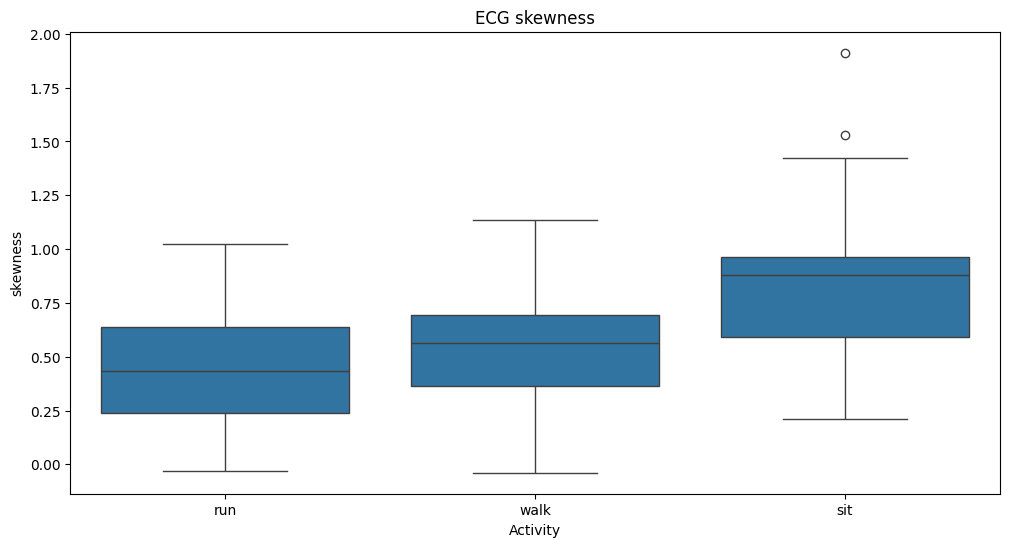

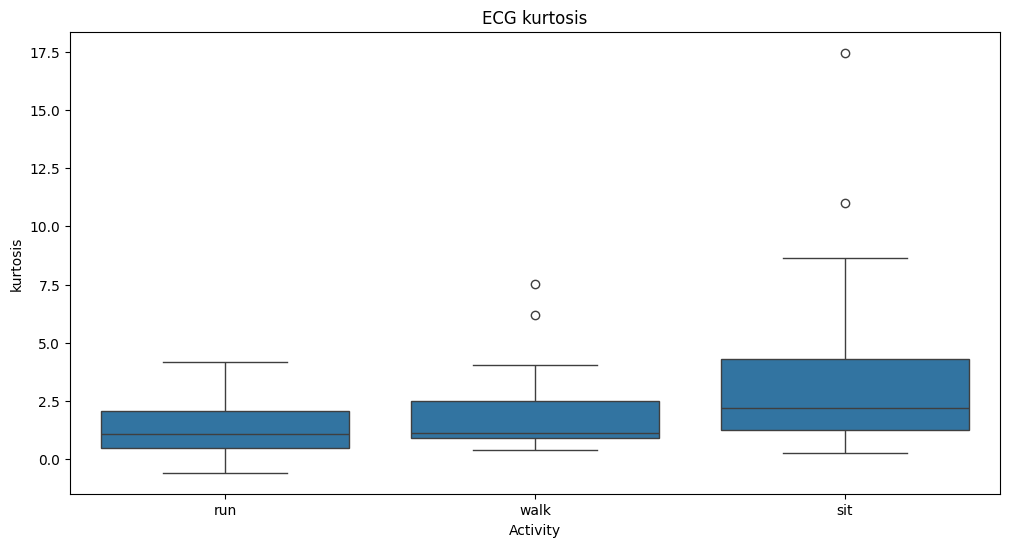

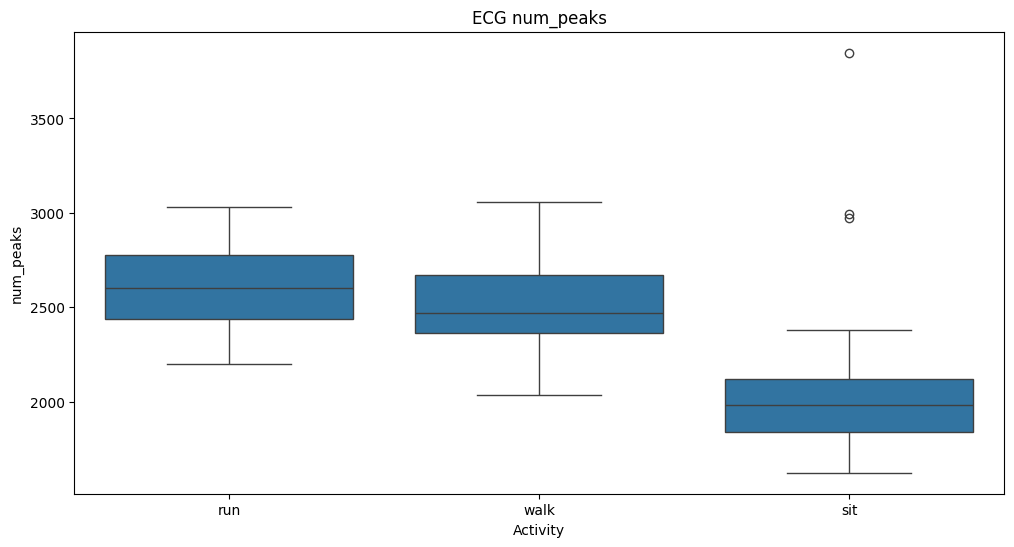

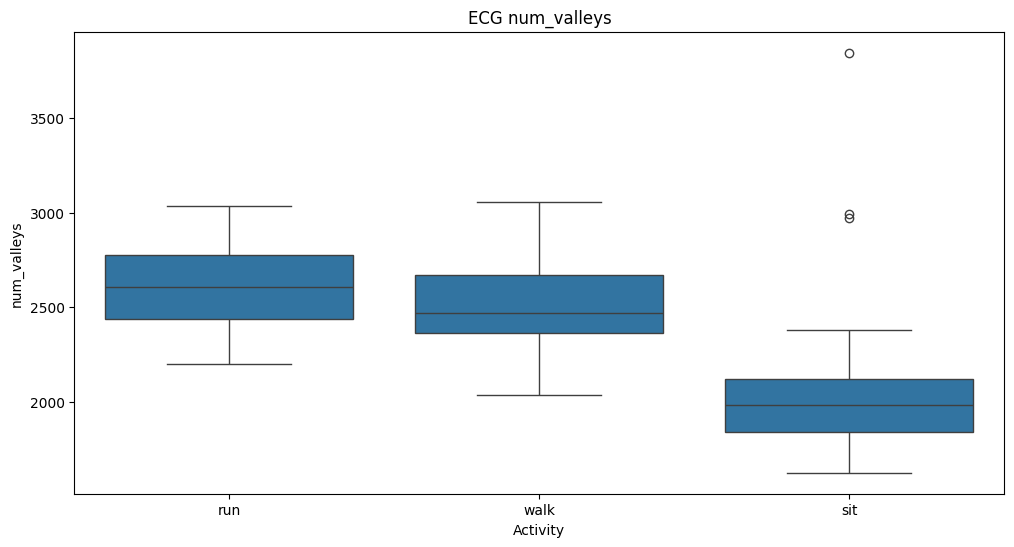

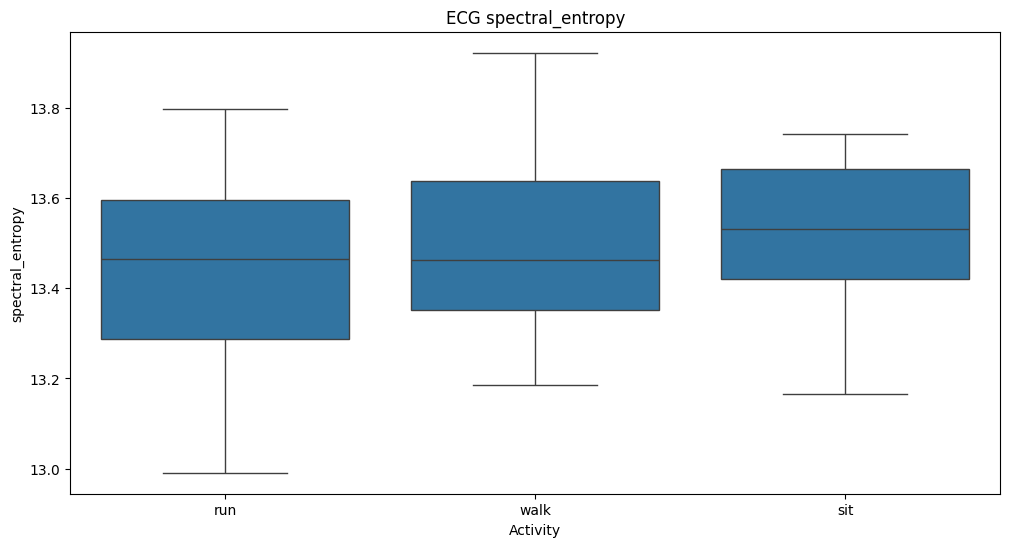

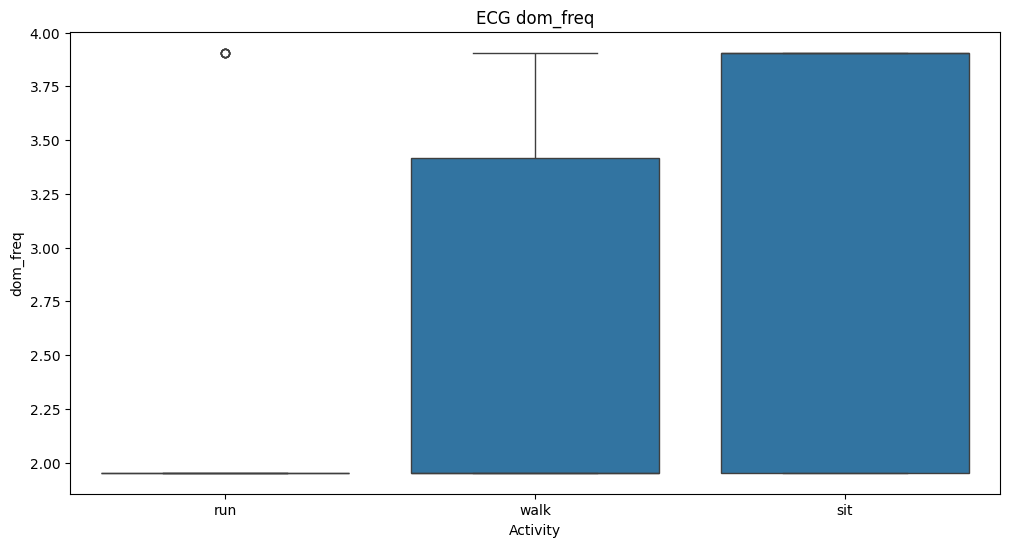

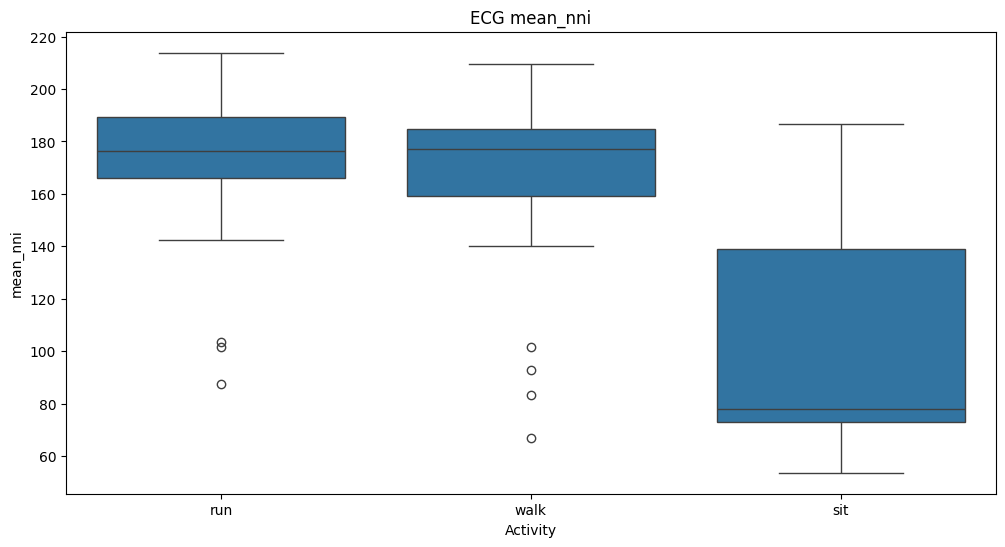

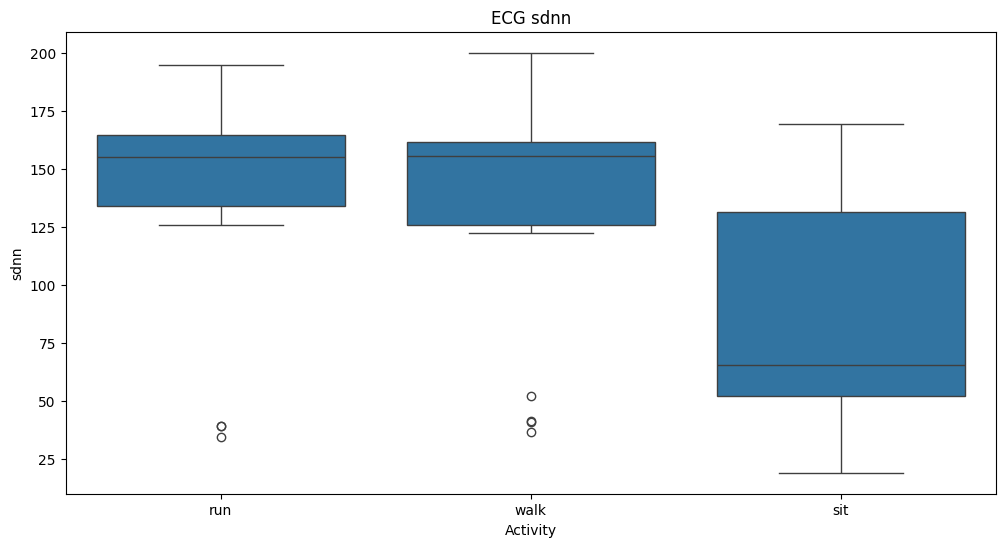

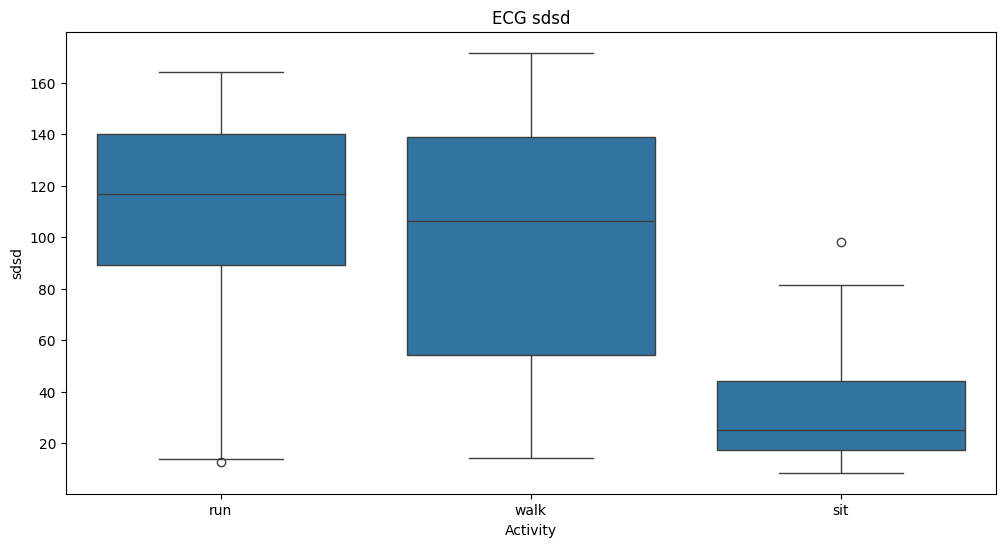

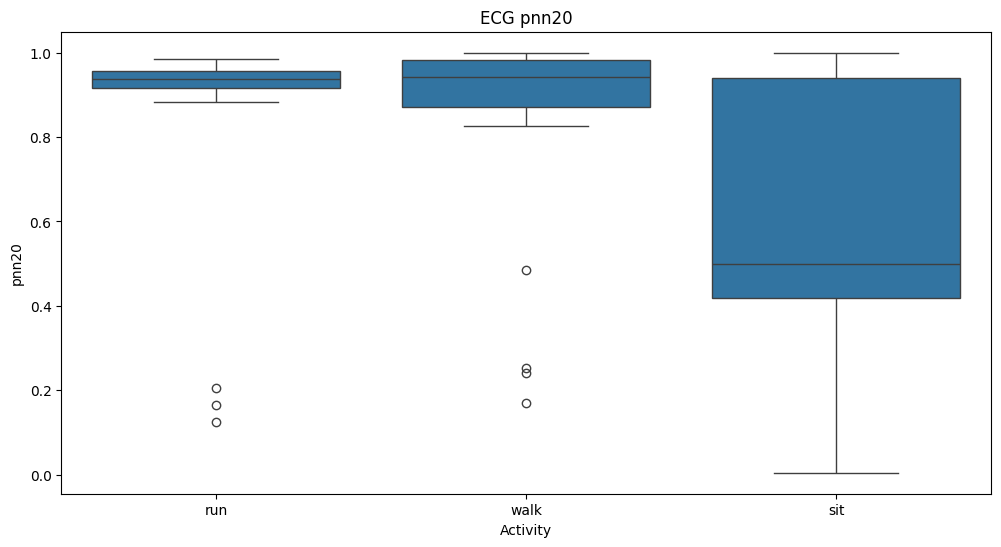

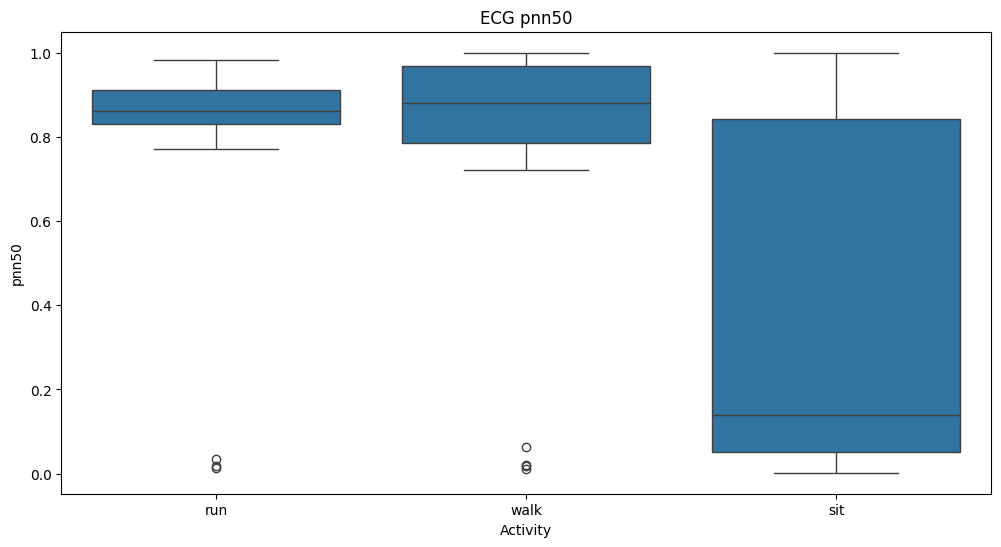

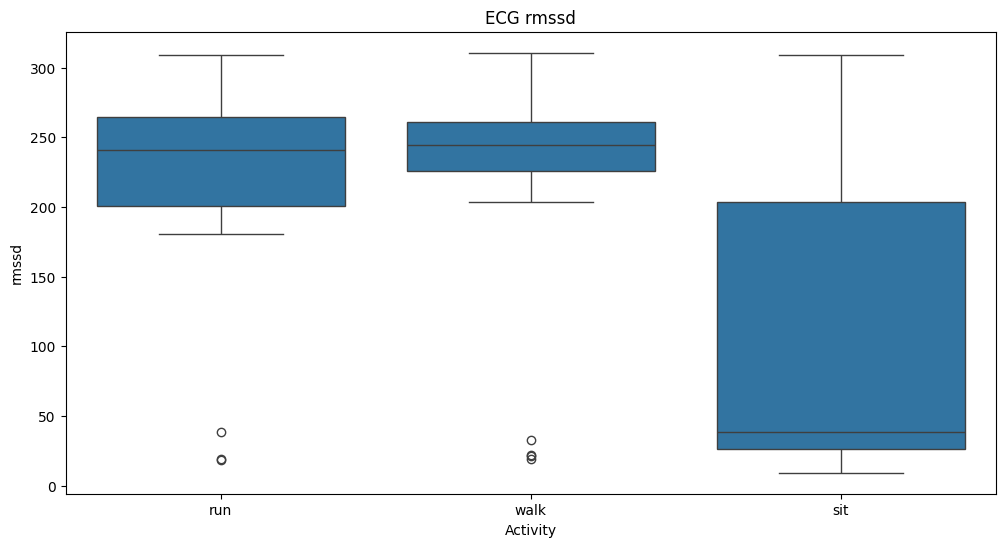

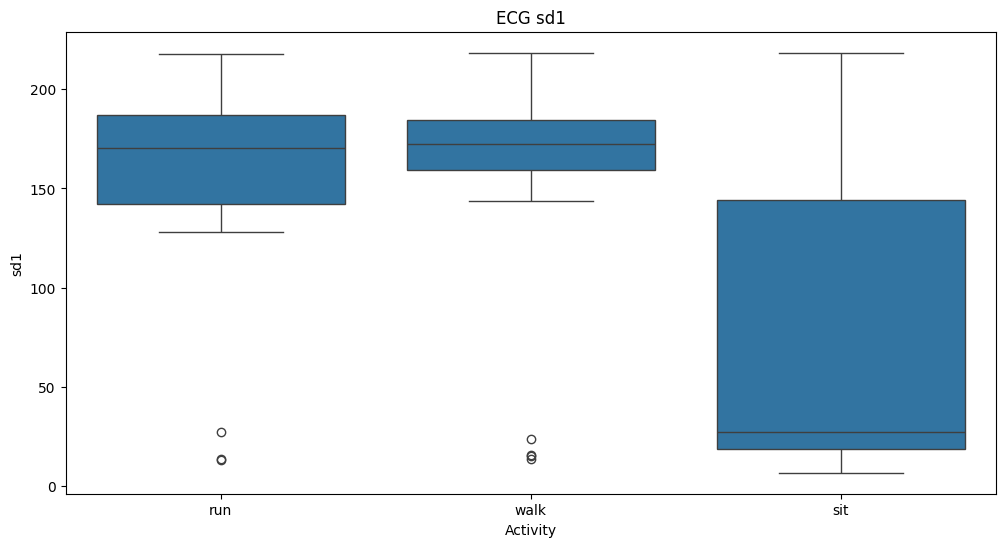

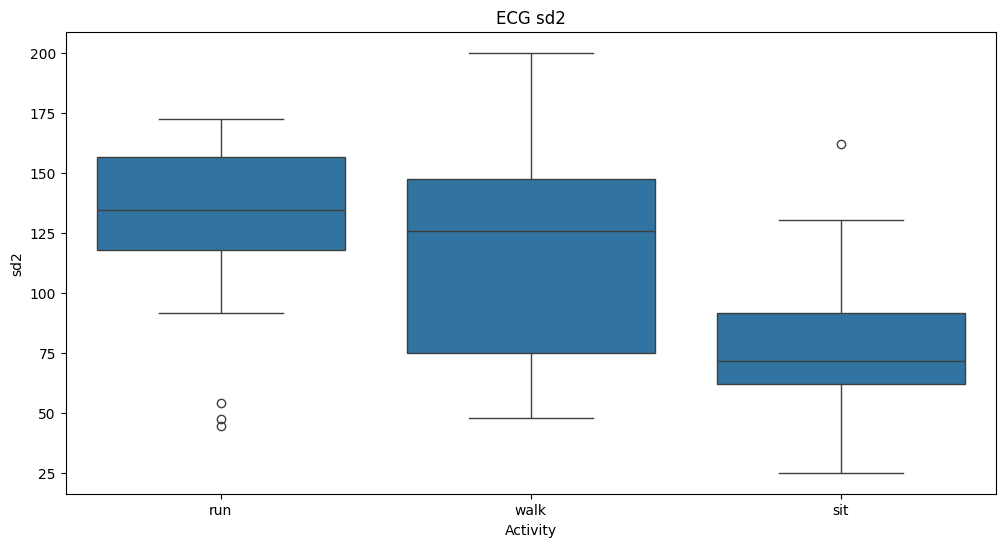

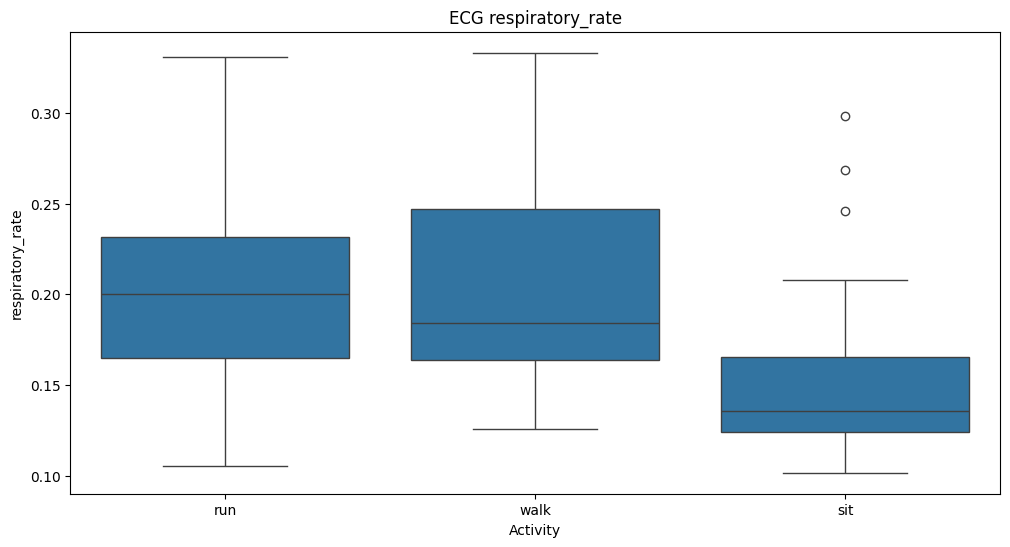

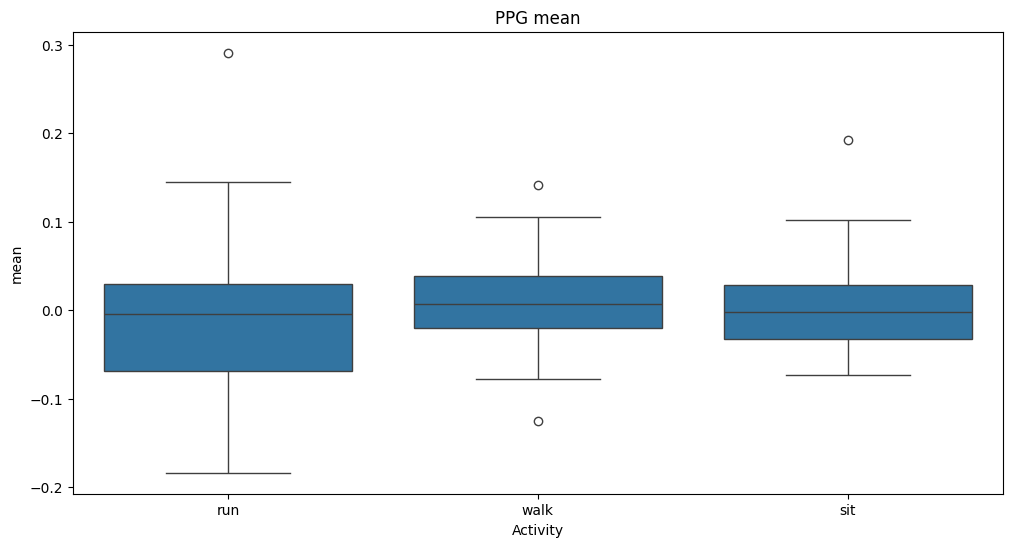

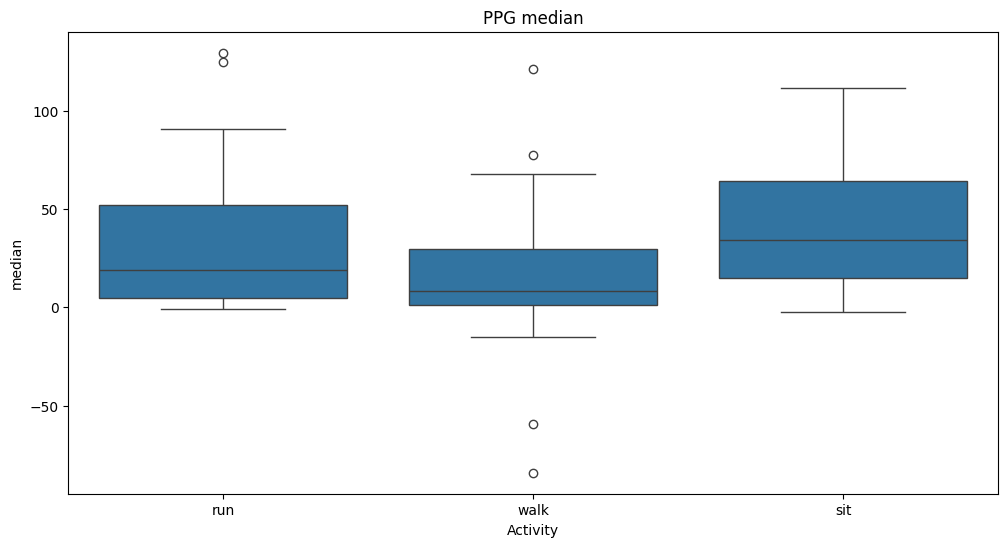

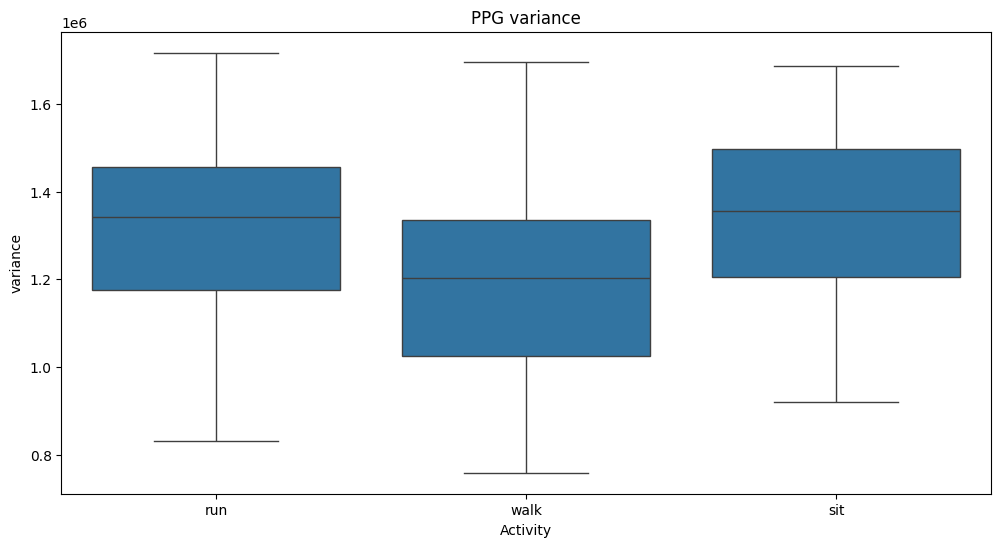

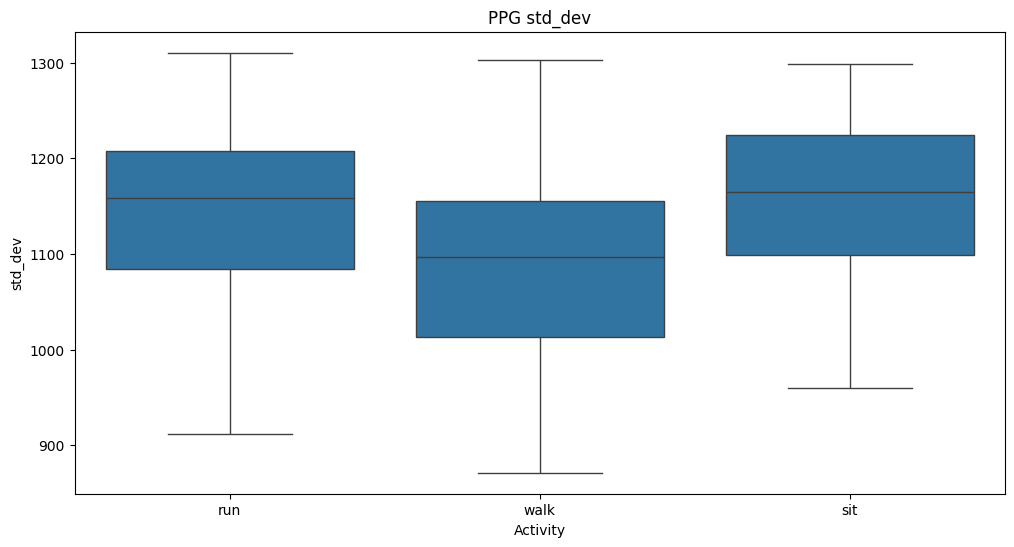

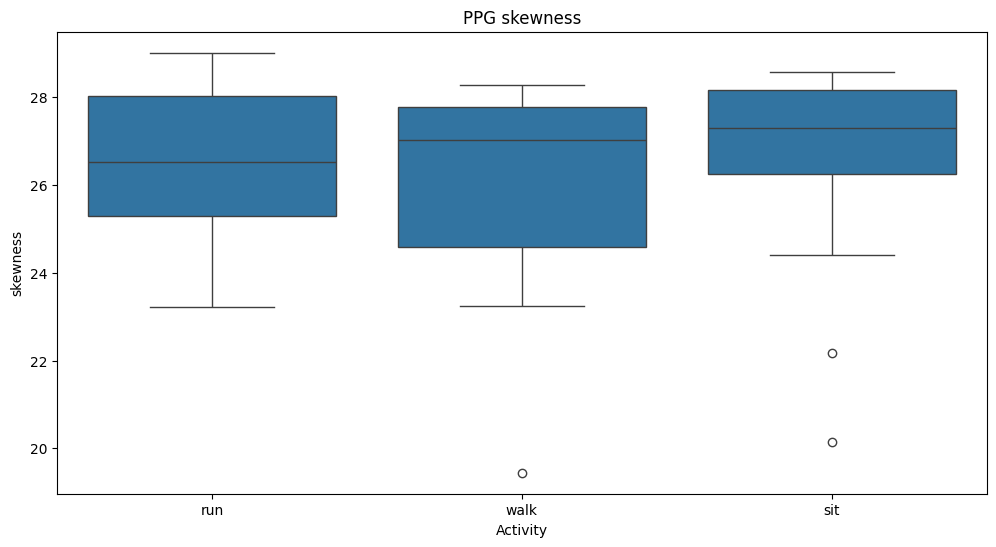

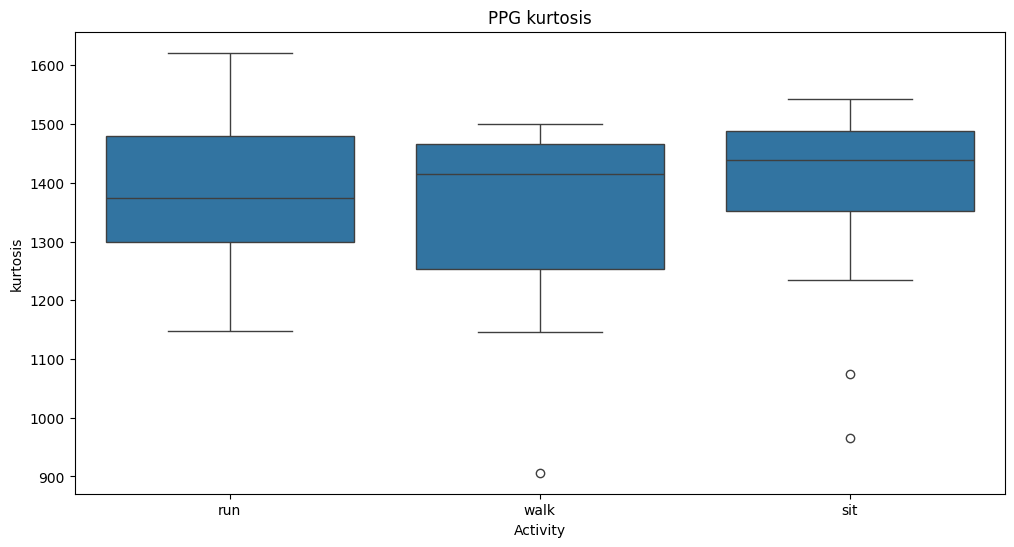

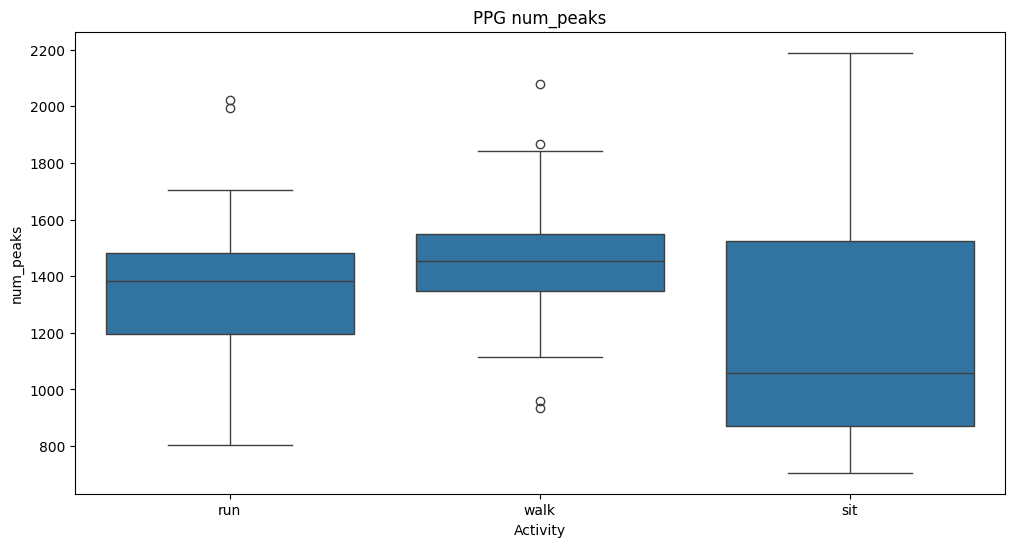

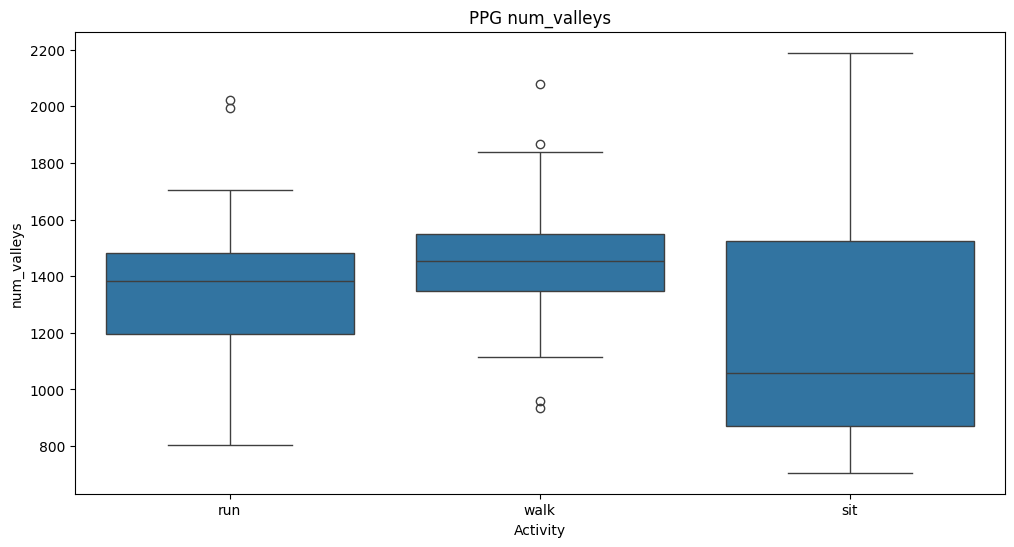

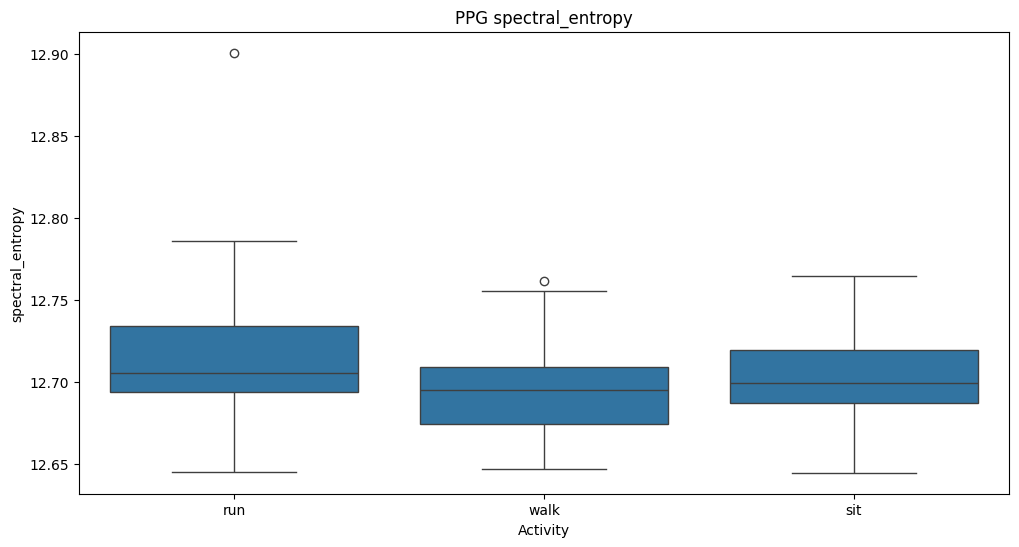

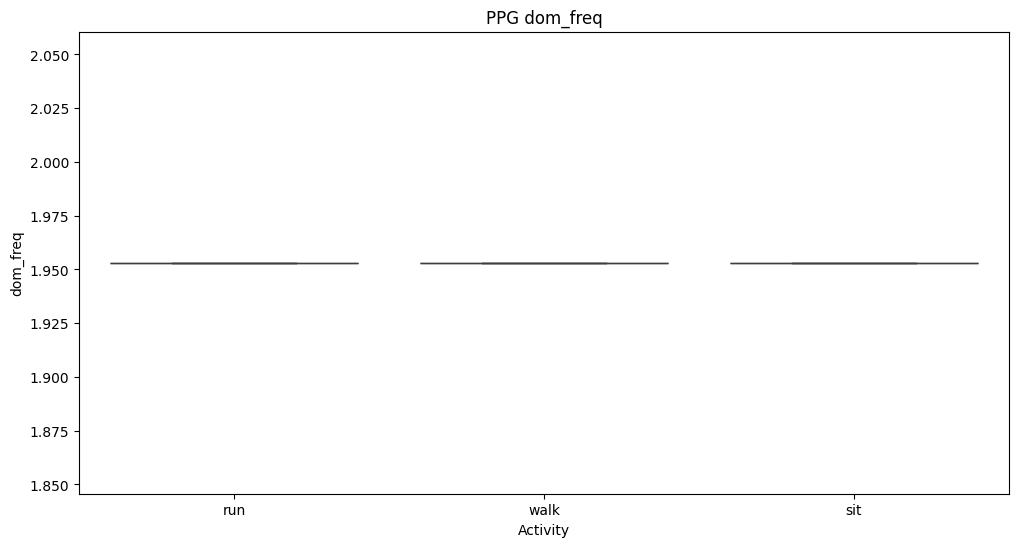

In [8]:
# Selected features for ECG and PPG
selected_keys_ecg = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurtosis', 'num_peaks', 'num_valleys', 'spectral_entropy', 'dom_freq', 'mean_nni','sdnn','sdsd','pnn20','pnn50','rmssd','sd1','sd2','respiratory_rate']
selected_keys_ppg = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurtosis', 'num_peaks', 'num_valleys', 'spectral_entropy', 'dom_freq']

import pandas as pd
import seaborn as sns

# Create DataFrames for ECG and PPG features
ecg_data = []
ppg_data = []
for label, features_list in features_by_label.items():
    for features in features_list:
        ecg_row = {feature_name: features[0][feature_name] for feature_name in selected_keys_ecg}
        ecg_row['Activity'] = label
        ecg_data.append(ecg_row)

        ppg_row = {feature_name: features[1][feature_name] for feature_name in selected_keys_ppg}
        ppg_row['Activity'] = label
        ppg_data.append(ppg_row)

ecg_df = pd.DataFrame(ecg_data)
ppg_df = pd.DataFrame(ppg_data)

# Plot box plots for selected ECG features
for feature_name in selected_keys_ecg:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Activity', y=feature_name, data=ecg_df)
    plt.title(f'ECG {feature_name}')
    plt.show()
    plt.close()

# Plot box plots for selected PPG features
for feature_name in selected_keys_ppg:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Activity', y=feature_name, data=ppg_df)
    plt.title(f'PPG {feature_name}')
    plt.show()
    plt.close()

##Local Features

In [9]:
import pandas as pd

# Selected features for ECG and PPG
selected_keys_ecg = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurtosis', 'num_peaks', 'num_valleys', 'spectral_entropy', 'dom_freq', 'mean_nni','sdnn','sdsd','pnn20','pnn50','rmssd','sd1','sd2','respiratory_rate']
selected_keys_ppg = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurtosis', 'num_peaks', 'num_valleys', 'spectral_entropy', 'dom_freq']

# Create lists to store local features for ECG and PPG
ecg_local_data = []
ppg_local_data = []

for filename in os.listdir(folder_path):
    if filename.endswith(".dat"):
        # Extract the label from the filename
        label = filename.split('_')[1].split('.')[0]

        # Construct the record name without extensions
        record_name = os.path.join(folder_path, filename.split('.')[0])

        # Load the record using wfdb
        record = wfdb.rdrecord(record_name)

        # Extract ECG and PPG signals
        ecg_index = record.sig_name.index('ecg')
        ecg_signal = record.p_signal[:, ecg_index]
        pleth_2_index = record.sig_name.index('pleth_2')
        pleth_2_signal = record.p_signal[:, pleth_2_index]

        # Calculate local features
        ecg_local_features = local_features(ecg_signal, fs, is_ecg=True)
        pleth_2_local_features = local_features(pleth_2_signal, fs)

        # Calculate and store local features, adding a record_id
        for window_num, window_features in enumerate(ecg_local_features):
            for key, value in window_features.items():
                if key in selected_keys_ecg:
                    row = {'feature': key, 'value': value, 'window': window_num, 'activity': label}
                    ecg_local_data.append(row)

        for window_num, window_features in enumerate(pleth_2_local_features):
            for key, value in window_features.items():
                if key in selected_keys_ppg:
                    row = {'feature': key, 'value': value, 'window': window_num, 'activity': label}
                    ppg_local_data.append(row)

ecg_local_df = pd.DataFrame(ecg_local_data)
ppg_local_df = pd.DataFrame(ppg_local_data)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


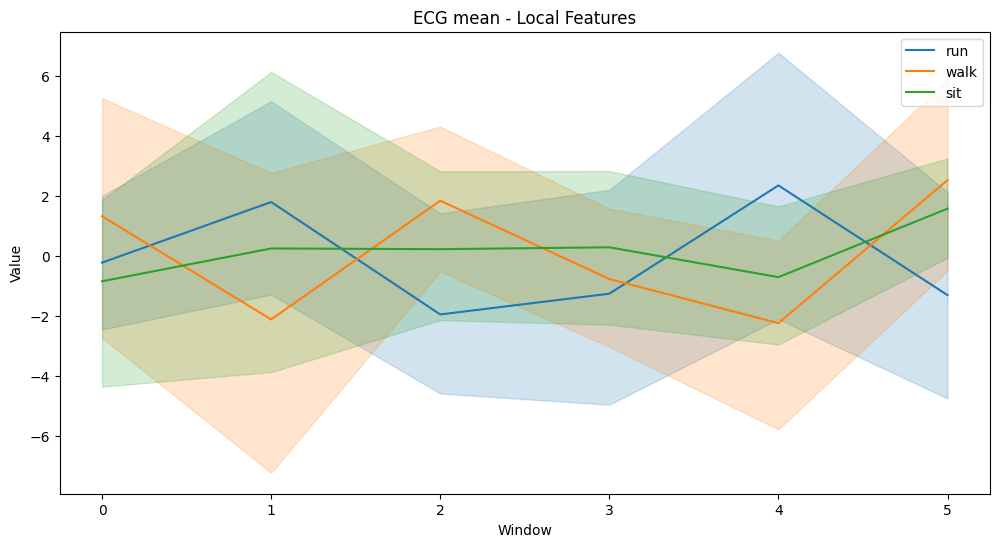

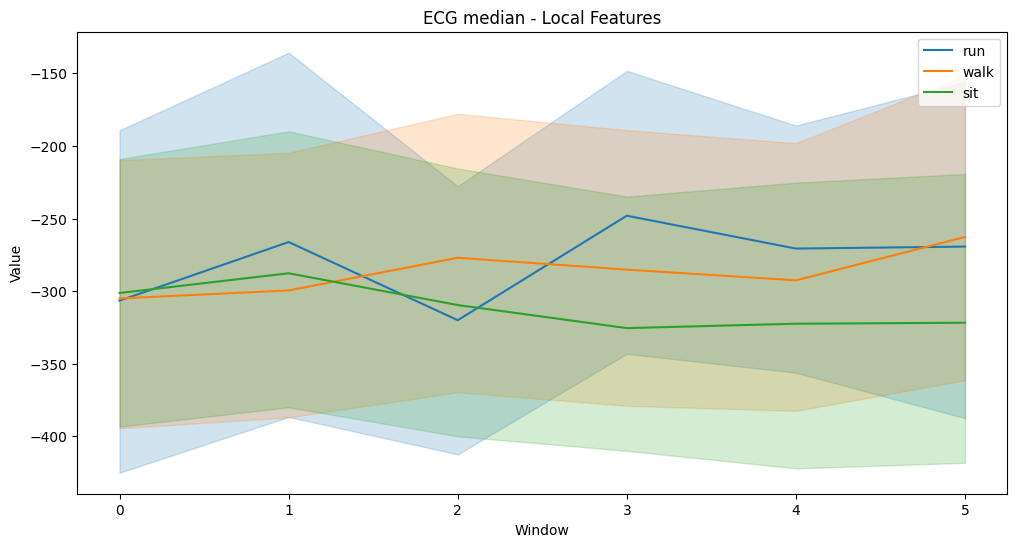

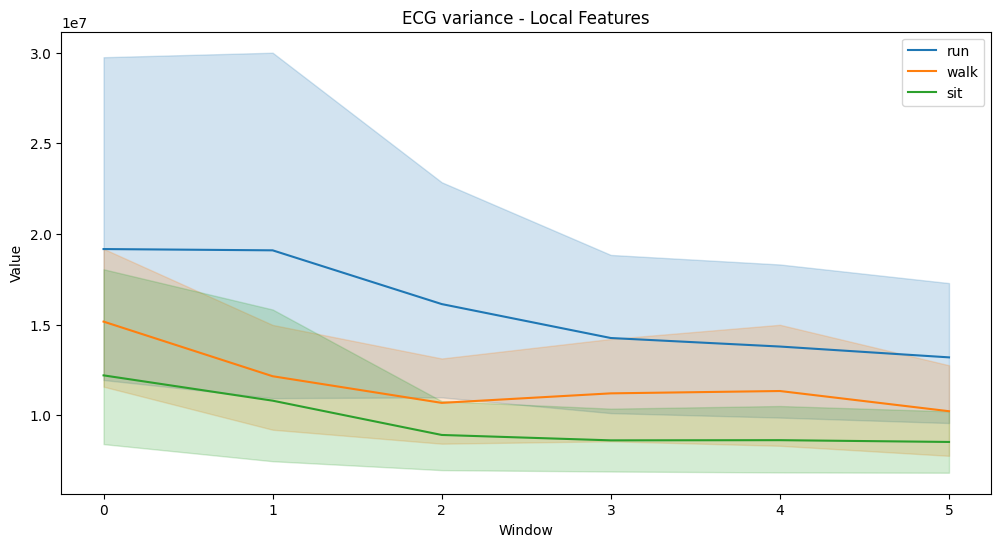

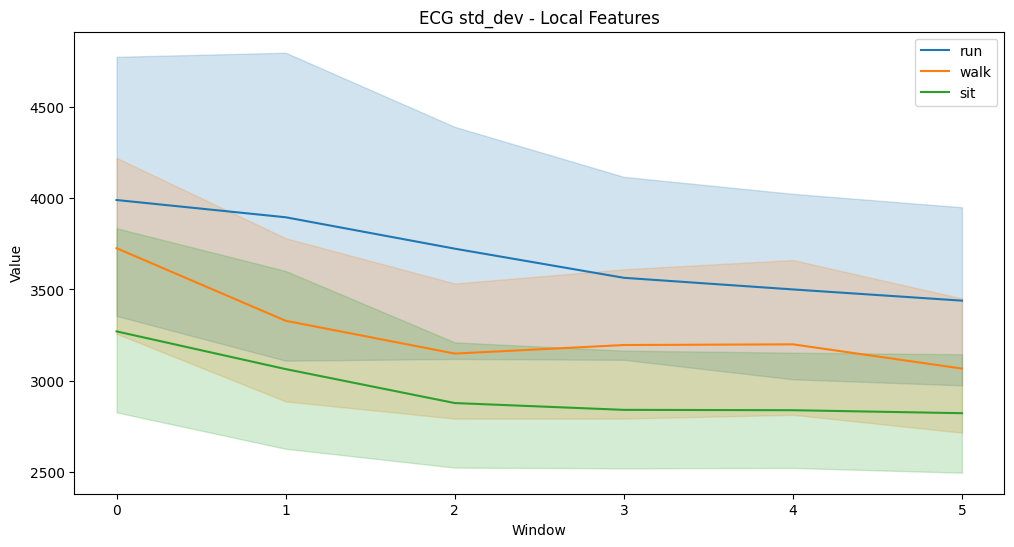

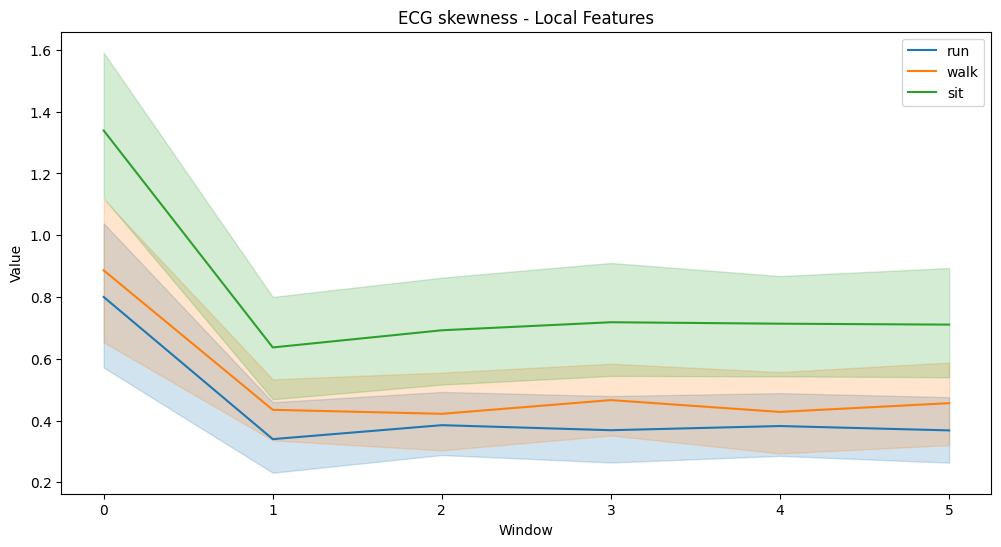

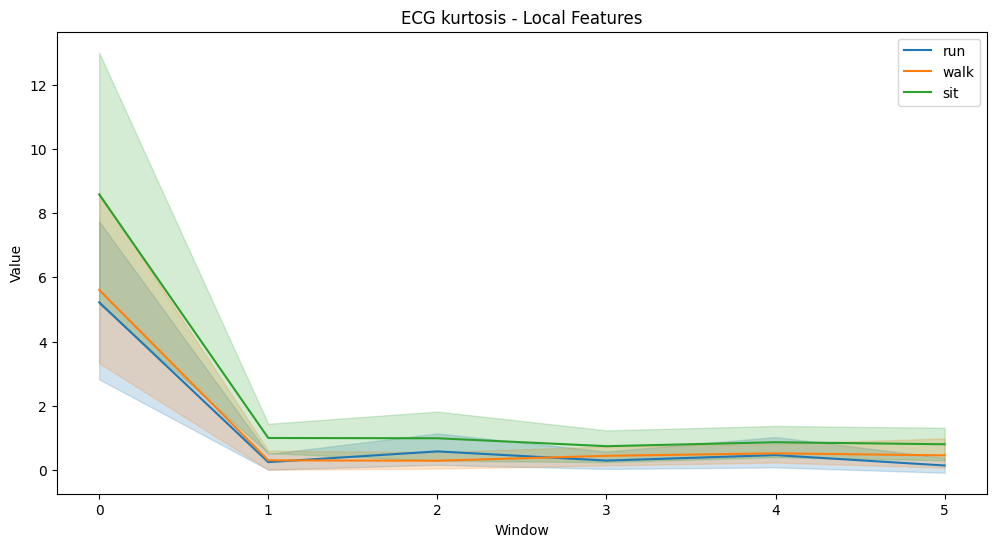

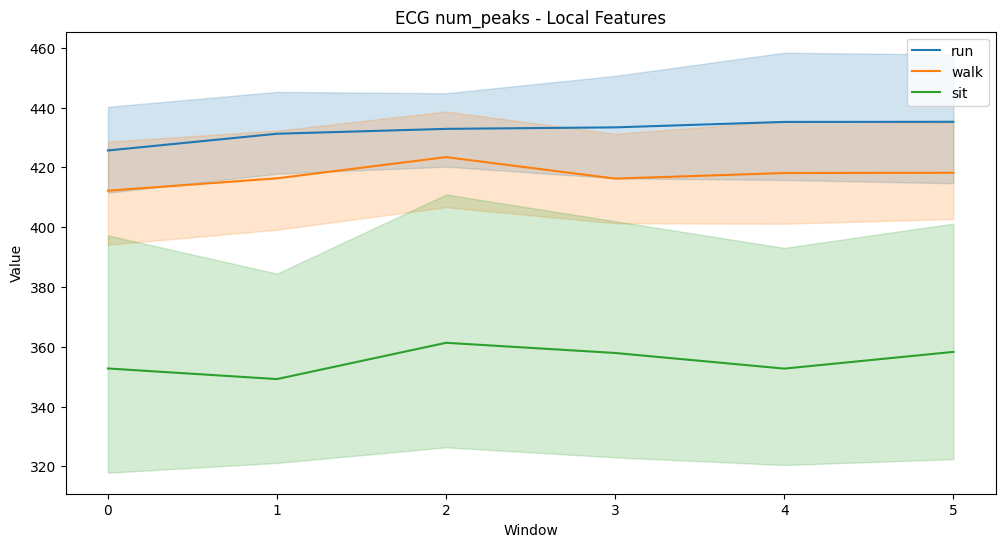

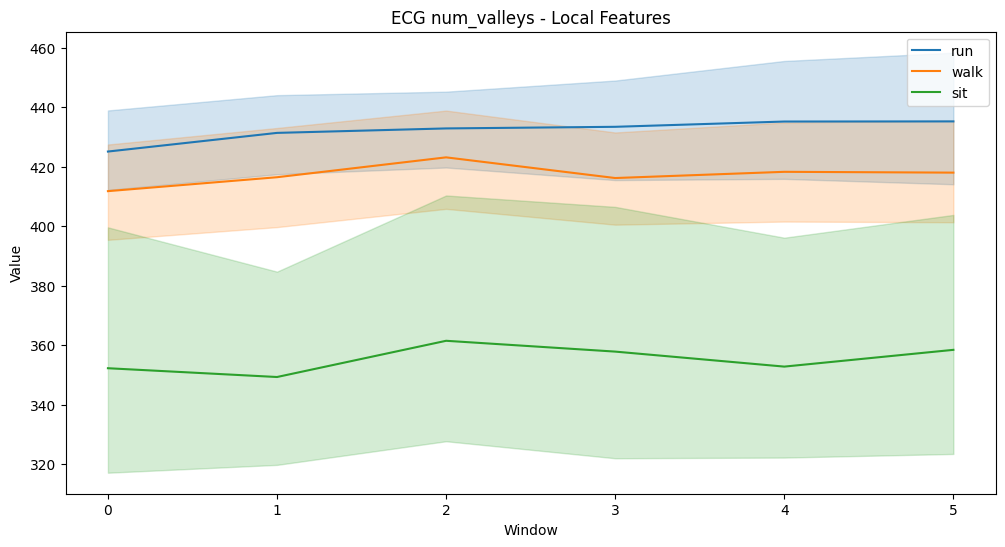

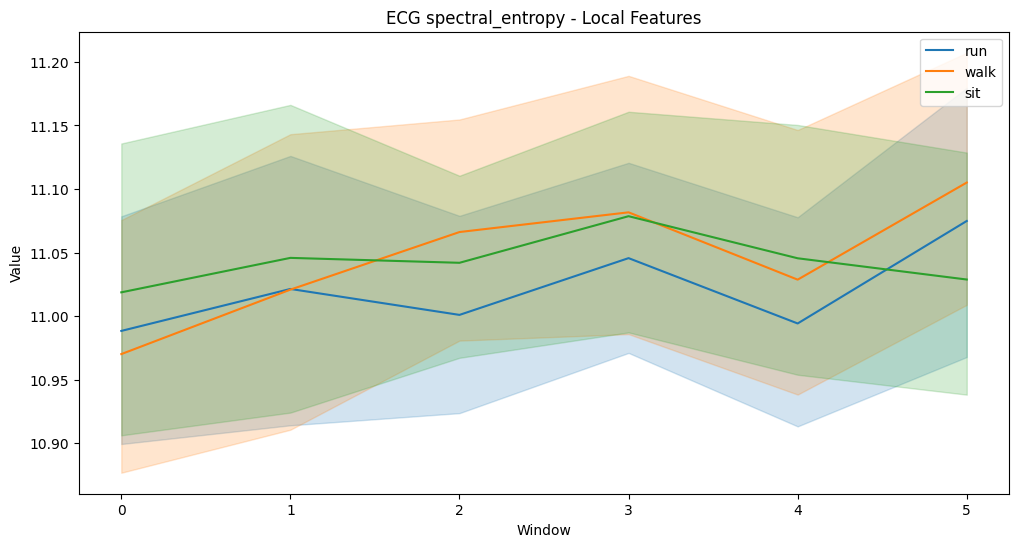

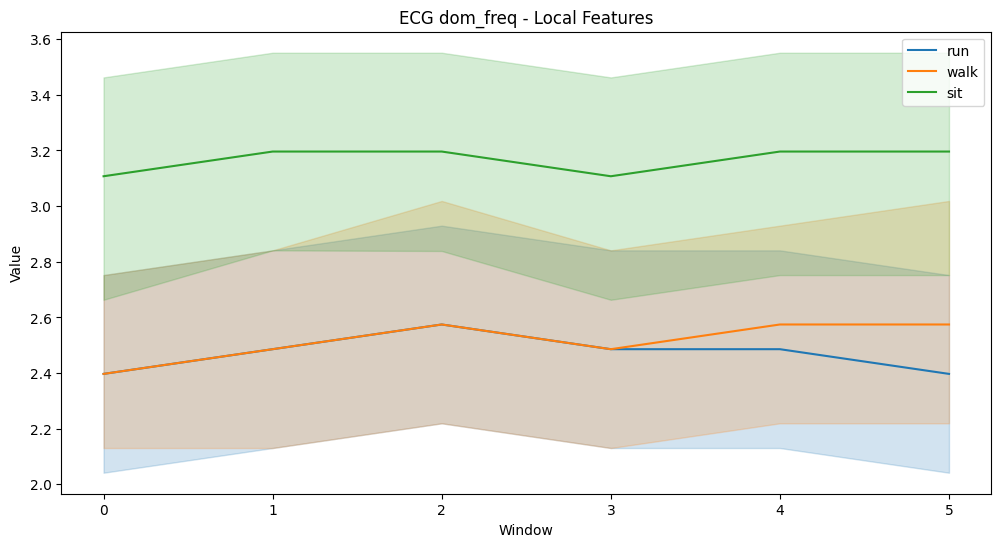

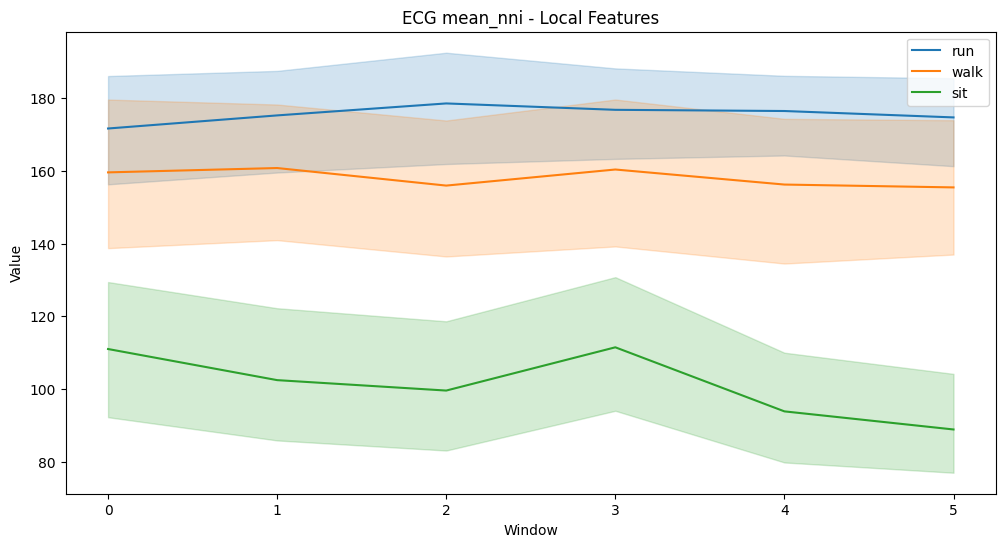

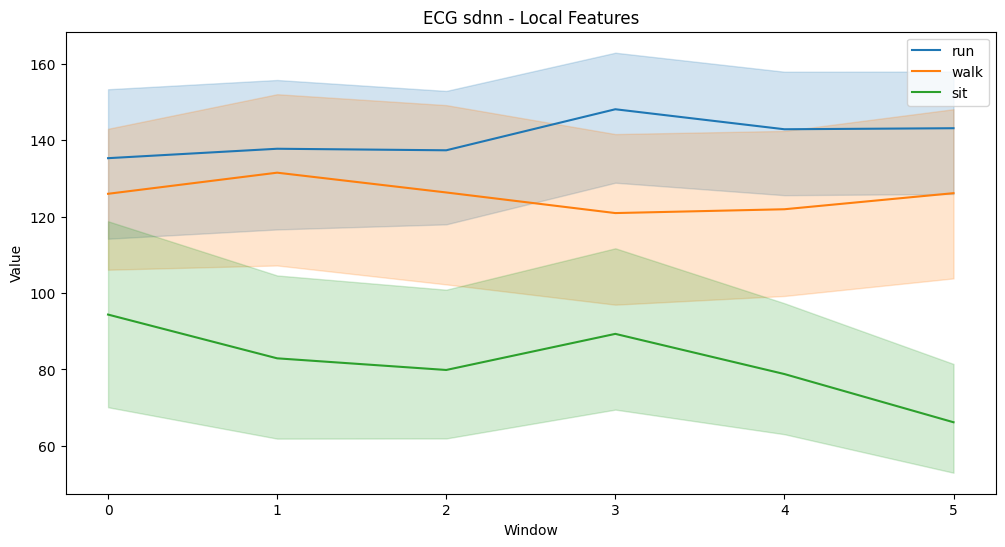

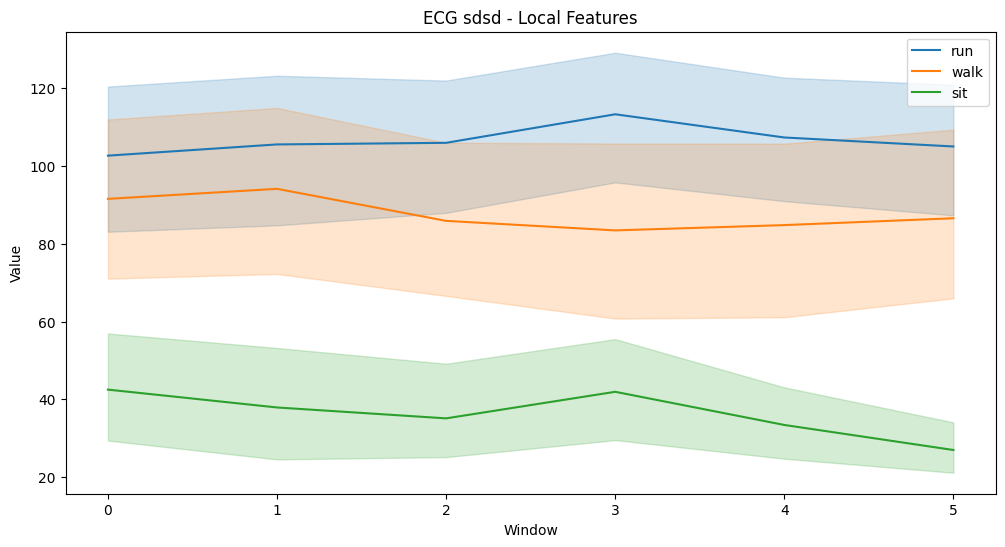

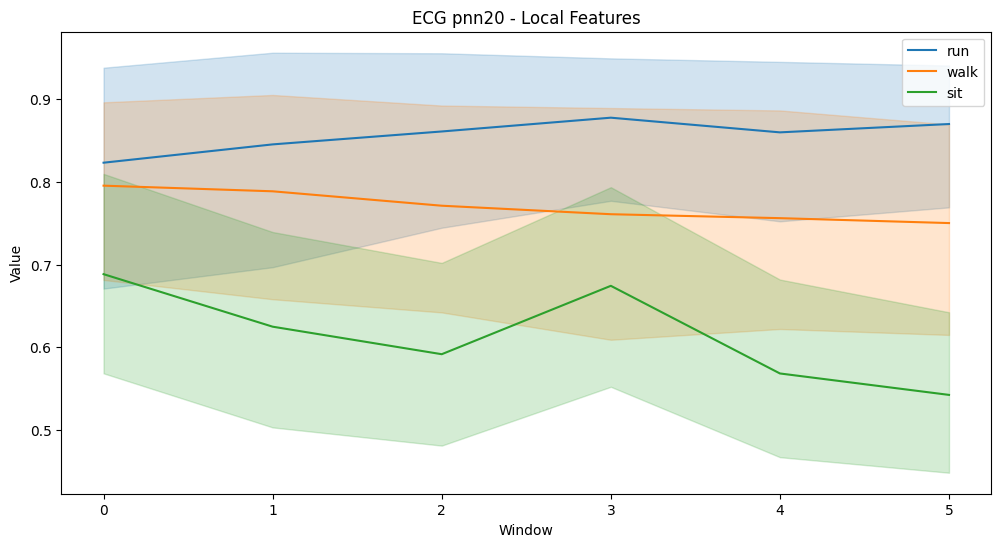

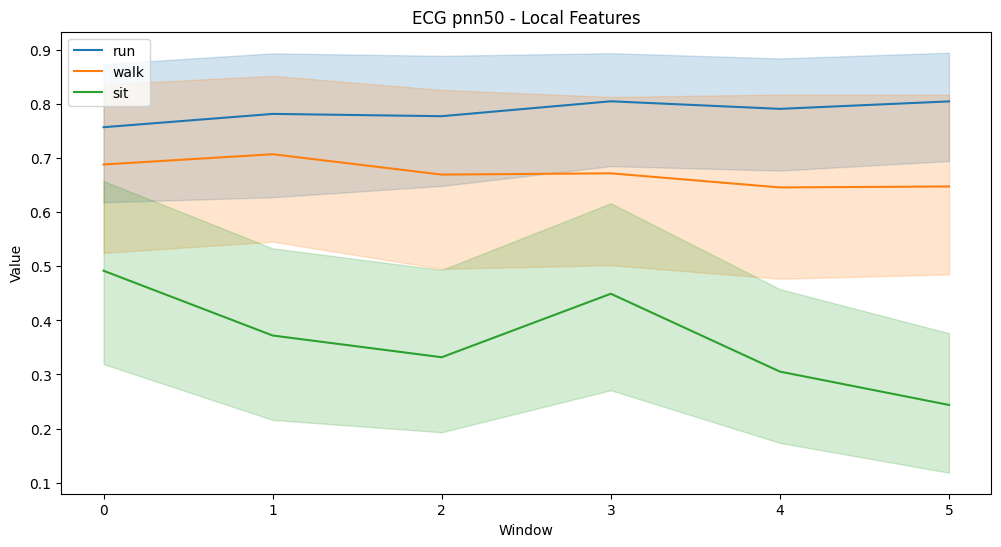

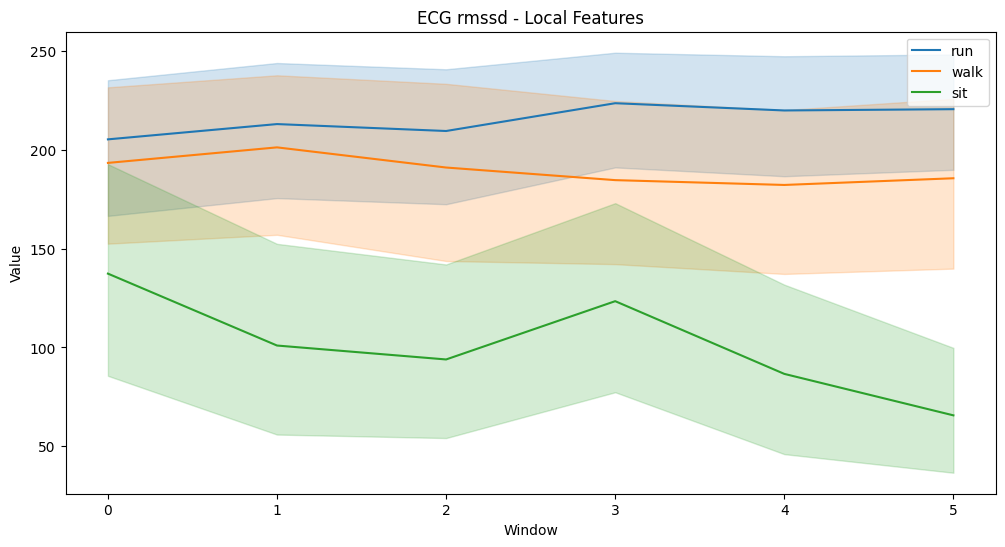

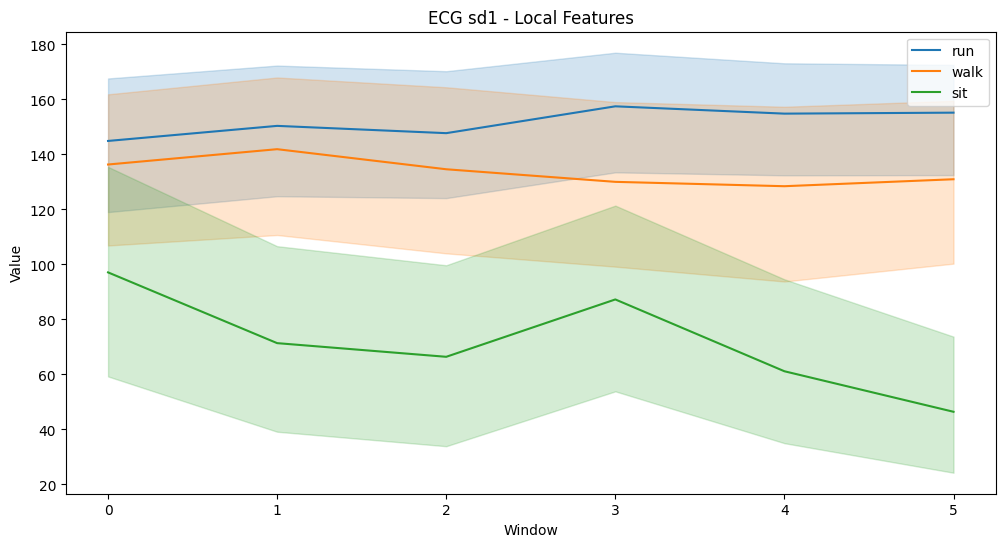

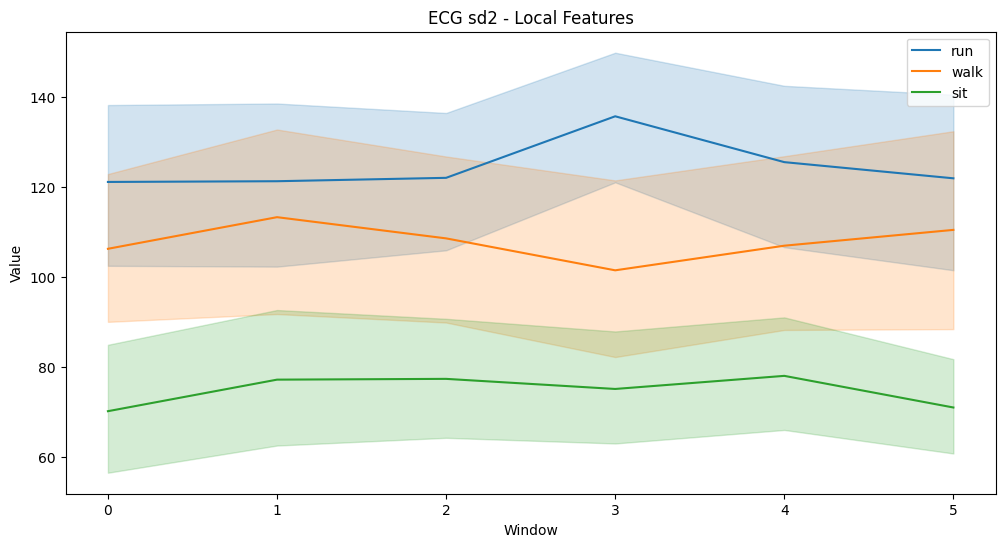

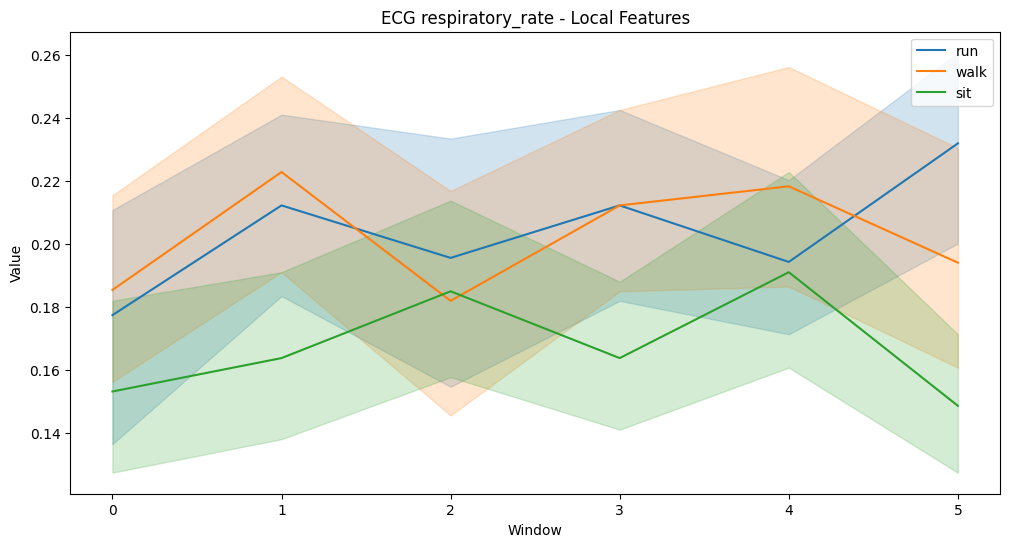

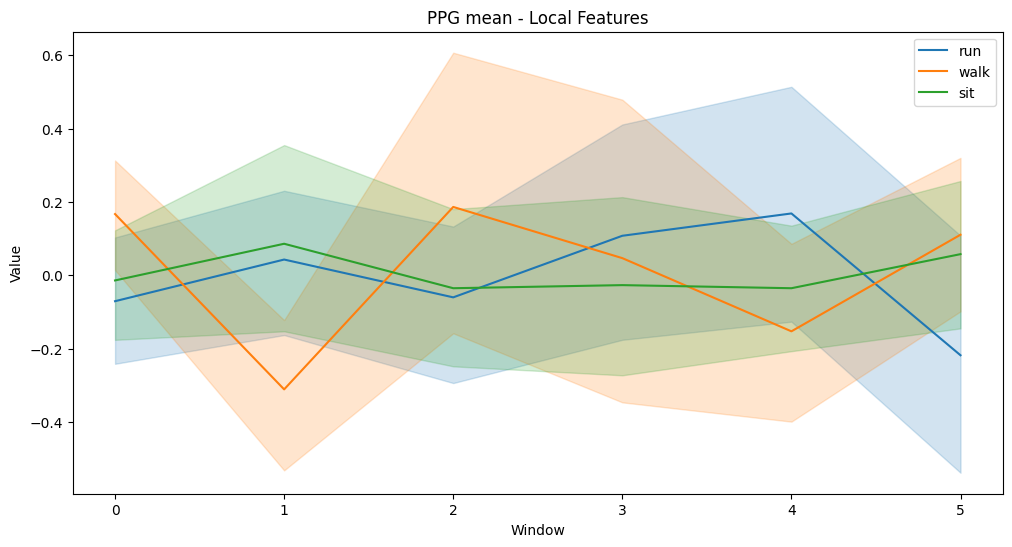

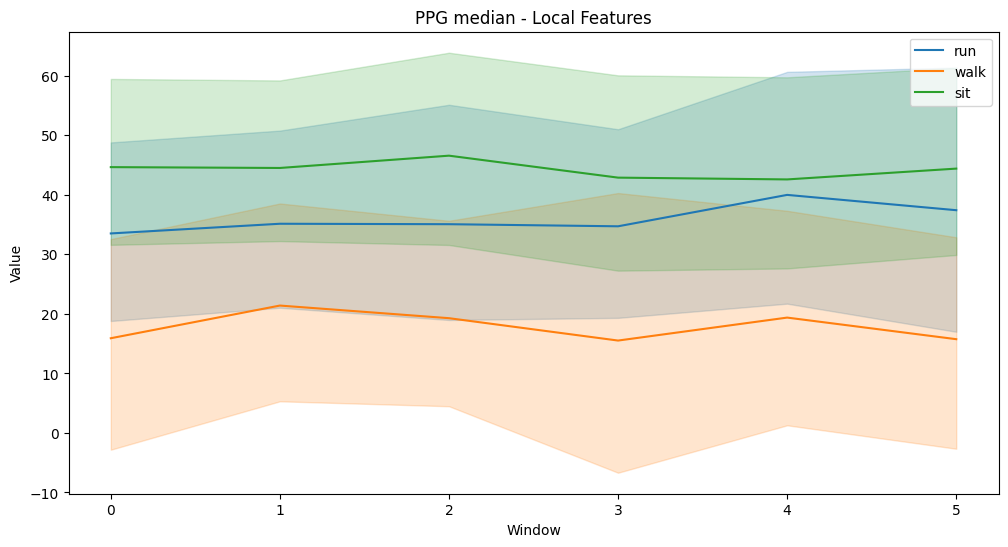

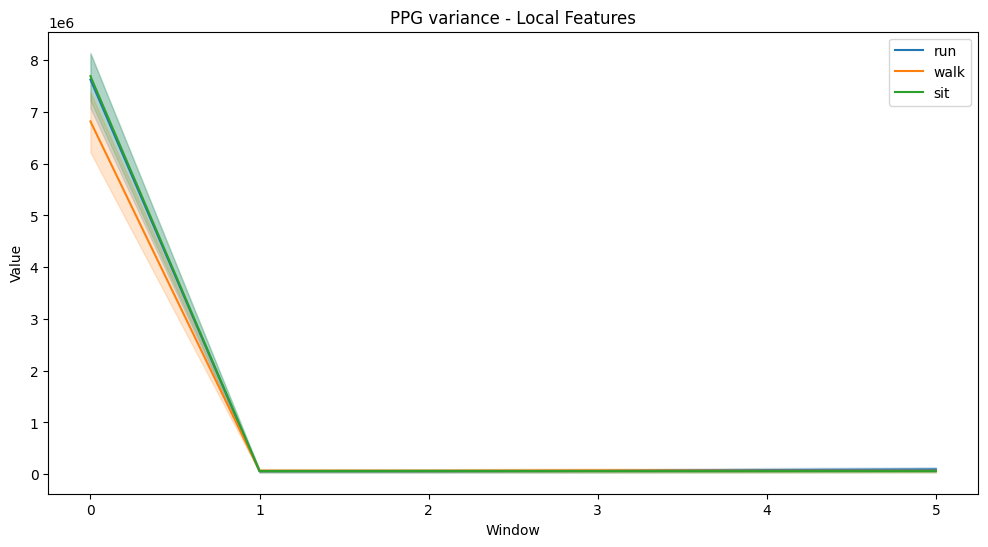

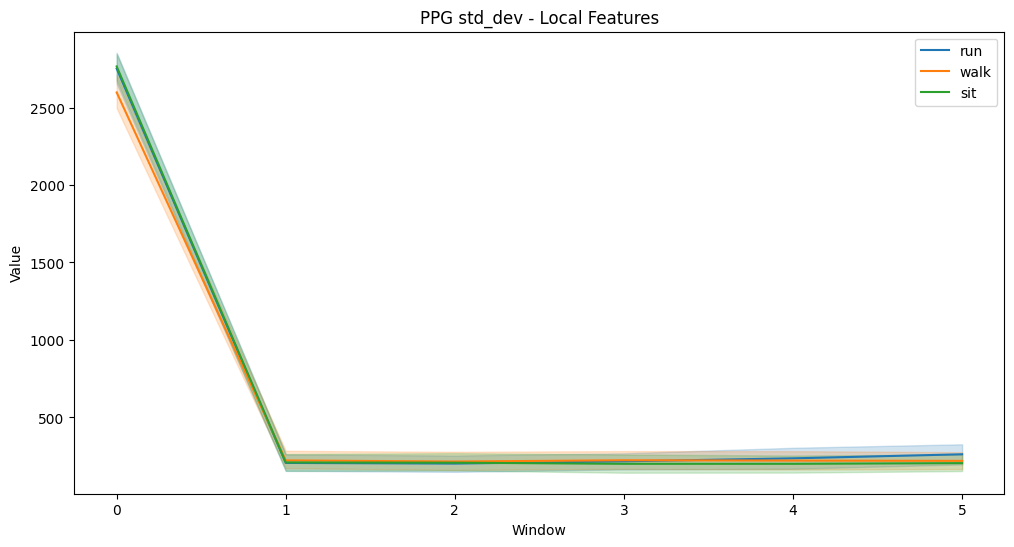

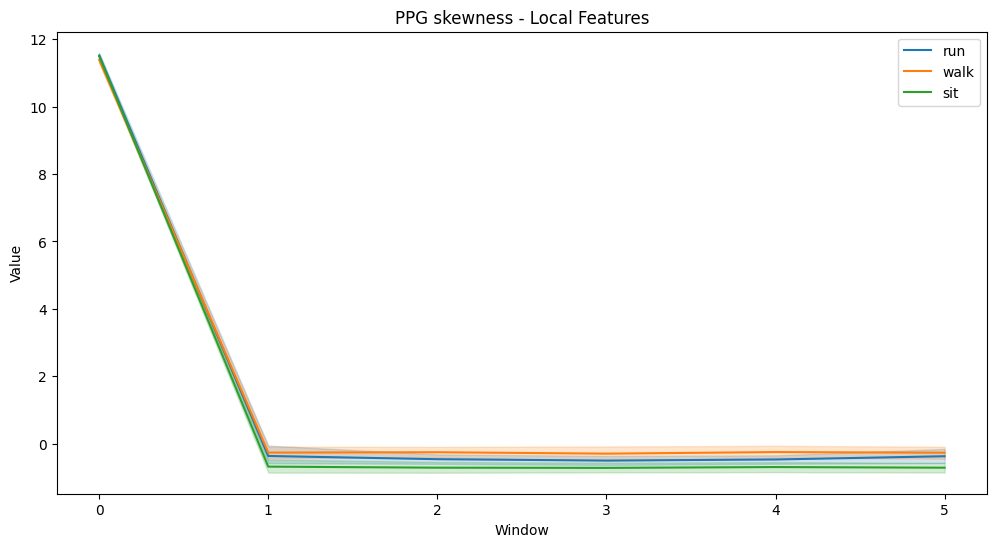

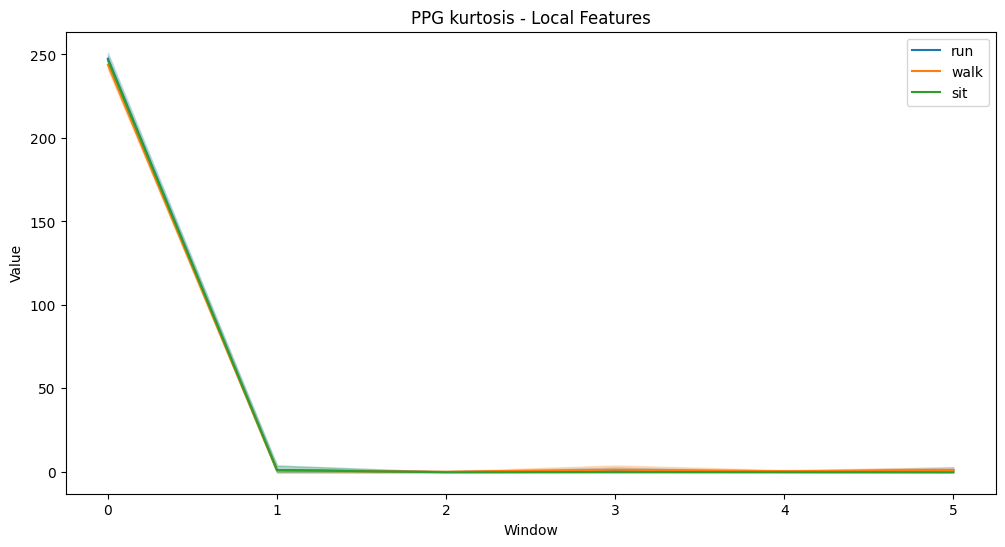

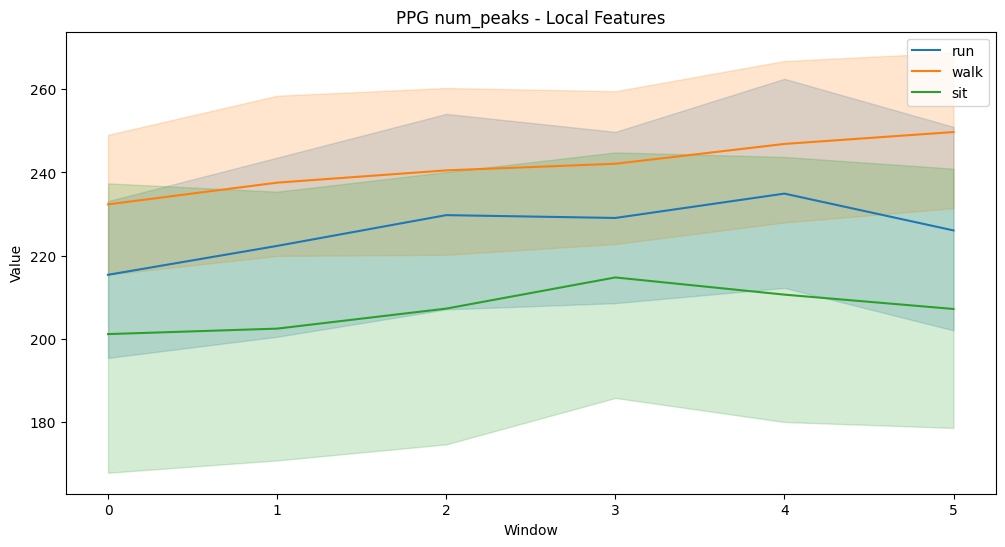

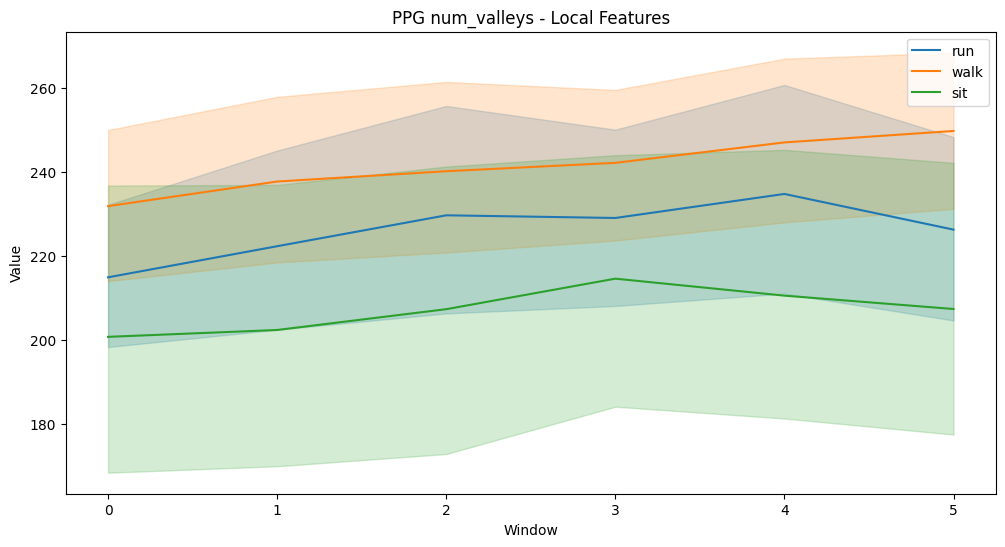

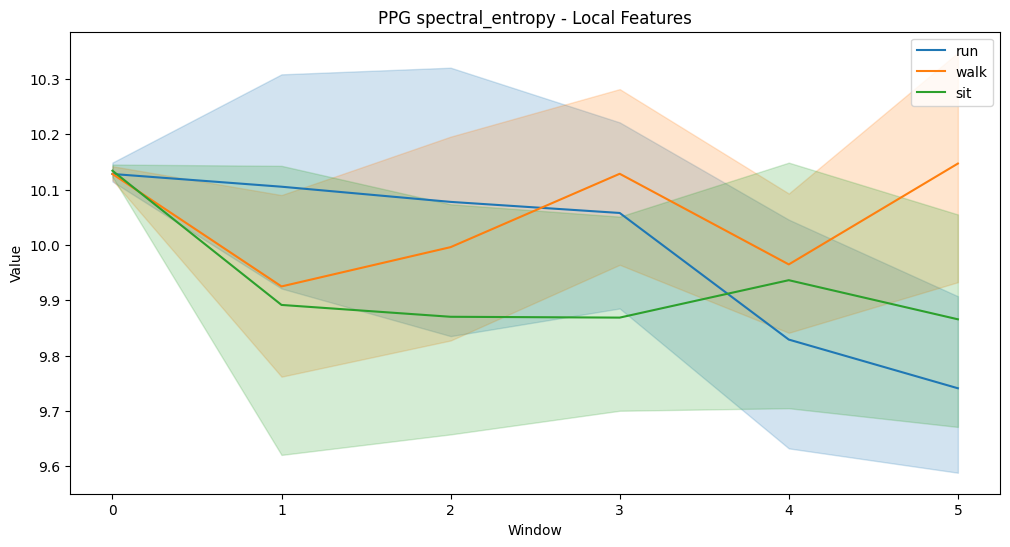

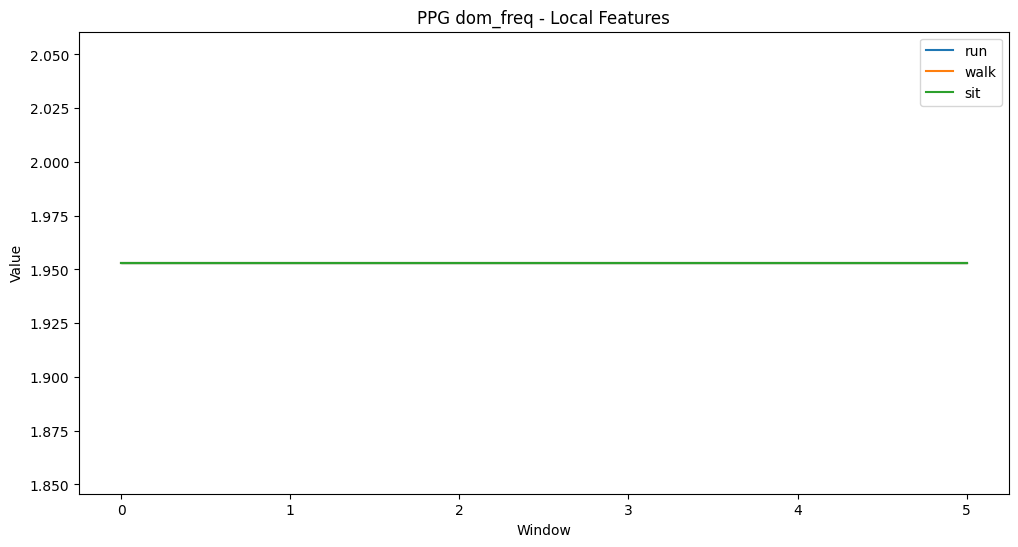

In [10]:
# Function to plot line graphs for local features
def plot_local_features(local_df, signal_type):
    for feature_name in local_df['feature'].unique():
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='window', y='value', hue='activity', data=local_df[local_df['feature'] == feature_name])
        plt.title(f'{signal_type} {feature_name} - Local Features')
        plt.xlabel('Window')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
        plt.close()

# Plot line graphs for selected local ECG features
plot_local_features(ecg_local_df, 'ECG')

# Plot line graphs for selected local PPG features
plot_local_features(ppg_local_df, 'PPG')